In [1]:
%%html
<style>@import url('style.css')</style>

# ESC: Dataset for Environmental Sound Classification

[Karol J. Piczak](mailto:karol@dvl.pl), Warsaw University of Technology  

---

Paper: **ESC: Dataset for environmental sound classification**, *ACMMM 2015* (*in press*) $\hspace{2em}$ Download: $\;$ [Whole dataset](http://dx.doi.org/10.7910/DVN/YDEPUT) $\;$ | $\;$ [ESC-50](https://github.com/karoldvl/ESC-50) $\;$ | $\;$ [ESC-10](https://github.com/karoldvl/ESC-10)

## Introduction

The **ESC dataset** is a freely available (*Creative Commons Attribution-NonCommercial license*) collection of short environmental recordings presented in a unified format (*5-second-long clips, 44100&nbsp;Hz, single channel, Ogg Vorbis compressed @ 192 kbit/s*). All clips have been extracted and manually labeled by the author from public field recordings available through the [Freesound.org project](http://freesound.org/). Please see the README files for a detailed attribution list.

The dataset consists of three parts:
- **ESC-50**: a labeled set of 2 000 environmental recordings (50 classes, 40 clips per class),
- **ESC-10**: a labeled set of 400 environmental recordings (10 classes, 40 clips per class) (this is a subset of *ESC-50* - created initialy as a proof-of-concept/standardized selection of easy recordings),
- **ESC-US**: an unlabeled dataset of 250 000 environmental recordings (5-second-long clips), suitable for unsupervised pre-training.

The *ESC-US* dataset, although not hand-annotated, includes the labels (tags) submitted by the original uploading users, which could be potentially used in weakly-supervised learning experiments (noisy and/or missing labels). The *ESC-10* and *ESC-50* datasets have been prearranged into 5 uniformly sized folds, making sure that clips extracted from the same original source recording are always contained in a single fold.

---

The goal of this project is to facilitate open research initatives in the field of environmental sound classification as [publicly available datasets](http://www.cs.tut.fi/~heittolt/datasets.html) in this domain are still quite scarce.

This Jupyter (IPython) notebook provides a quick way to start analyzing this dataset. It gives an overview of the underlying data, shows some baseline machine classification results as compared to human performance, and helps replicate the figures/results presented in the actual paper.

#### Acknowledgments

I would like to thank [Frederic Font Corbera](http://www.dtic.upf.edu/~ffont/) from [Freesound](http://freesound.org)/[Music Technology Group at Universitat Pompeu Fabra](http://www.mtg.upf.edu/) for his help in using the Freesound API.

# Setup

This notebook requires some libraries and tools to work as intended. A quick way to get it working is to use a [Dockerfile](https://docs.docker.com/reference/builder/) similar to this:

    FROM ipython/scipyserver

    MAINTAINER Karol Piczak <karol@dvl.pl>

    RUN apt-get update && apt-get install -y libav-tools libsamplerate0 libsamplerate0-dev

    RUN pip2 install librosa pydub scikits.samplerate openpyxl

So, let's begin by downloading the datasets:

In [27]:
import os
import shutil
import urllib.request
import zipfile
import glob

def download_dataset(name):
    """Download the dataset into current working directory."""
    if not os.path.exists(name):
        os.mkdir(name)
        urllib.request.urlretrieve('https://github.com/karoldvl/{0}/archive/master.zip'.format(name), '{0}/{0}.zip'.format(name))

        with zipfile.ZipFile('{0}/{0}.zip'.format(name)) as package:
            package.extractall('{0}/'.format(name))

        os.unlink('{0}/{0}.zip'.format(name))        

        for src in glob.glob('{0}/{0}-master/*'.format(name)):
            shutil.move(src, '{0}/{1}'.format(name, os.path.basename(src)))

        os.rmdir('{0}/{0}-master'.format(name))
        
download_dataset('ESC-10')
download_dataset('ESC-50')

The *ESC-10* dataset consists of 10 categories of recordings (400 clips):

In [28]:
ls ESC-10

 Volume in drive C is Windows
 Volume Serial Number is 965E-07F4

 Directory of C:\Users\nEW u\Desktop\ESC-10

10-Sep-18  01:43 AM    <DIR>          .
10-Sep-18  01:43 AM    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  292,775,157,760 bytes free


*ESC-50* has 50 classes (2 000 clips) in 5 thematic groups:
- Animals (101-110)
- Natural soundscapes & water sounds (201-210)
- Human (non-speech) sounds (301-310)
- Interior/domestic sounds (401-410)
- Exterior/urban noises (501-510)

In [29]:
ls ESC-50

 Volume in drive C is Windows
 Volume Serial Number is 965E-07F4

 Directory of C:\Users\nEW u\Desktop\ESC-50

10-Sep-18  01:53 AM    <DIR>          .
10-Sep-18  01:53 AM    <DIR>          ..
10-Sep-18  01:53 AM    <DIR>          ESC-50-master
               0 File(s)              0 bytes
               3 Dir(s)  292,709,752,832 bytes free


# Exploratory analysis

First, we need to define a helper class. It will load the recordings and compute some baseline features. We will be using the [LibROSA package](https://github.com/bmcfee/librosa/tree/v0.3.1) for some of the implementations.

In [54]:
import numpy as np
import pydub
import librosa

class Clip:
    """A single 5-sec long recording."""
    
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds
            self.data = pydub.AudioSegment.silent(duration=5000)
            self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path)[0:5000])
            self.raw = (np.fromstring(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)   # convert to float
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1]
        
        self.audio = Clip.Audio(self.path)
        
        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)
            
    def _compute_mfcc(self, audio):
        # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
        self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.power_to_db = librosa.power_to_db(self.melspectrogram)
        self.mfcc = librosa.feature.mfcc(S=self.power_to_db, n_mfcc=13).transpose()
            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.FRAME))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.FRAME):(index+1) * Clip.FRAME]
    
    def __repr__(self):
        return '<{0}/{1}>'.format(self.category, self.filename)

Just to be sure that everything is working, we can look at some specific recordings:

In [55]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sb
sb.set(style="white", palette="muted")

import pandas as pd

In [56]:
import random
random.seed(20150420)

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


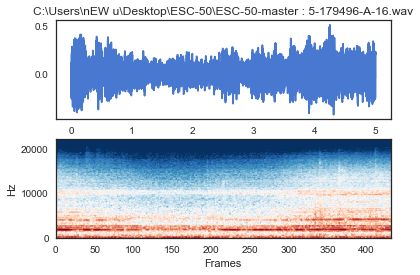

In [58]:
# You can reload this cell to get a different clip at every try

import IPython.display
import librosa.display

all_recordings = glob.glob('ESC-50/*/*.wav')
clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

with clip.audio as audio:
    plt.subplot(2, 1, 1)
    plt.title('{0} : {1}'.format(clip.category, clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(clip.power_to_db, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r')
    
IPython.display.Audio(filename=clip.path, rate=Clip.RATE)    

Now, let's load all the recordings at once:

In [59]:
def load_dataset(name):
    """Load all dataset recordings into a nested list."""
    clips = []
    
    for directory in sorted(os.listdir('{0}/'.format(name))):
        directory = '{0}/{1}'.format(name, directory)
        if os.path.isdir(directory) and os.path.basename(directory)[0:3].isdigit():
            print('Parsing ' + directory)
            category = []
            for clip in sorted(os.listdir(directory)):
                if clip[-3:] == 'wav':
                    category.append(Clip('{0}/{1}'.format(directory, clip)))
            clips.append(category)
            
    IPython.display.clear_output()
    print('All {0} recordings loaded.'.format(name))            
    
    return clips

clips_10 = load_dataset('ESC-10')

All ESC-10 recordings loaded.


To get a feel of the data, we can perform some exploratory visual analysis.



In [ ]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], axisbg='w')

First, let's have a look at an overview of the waveforms and mel-spectrograms through the whole dataset.

IndexError: list index out of range

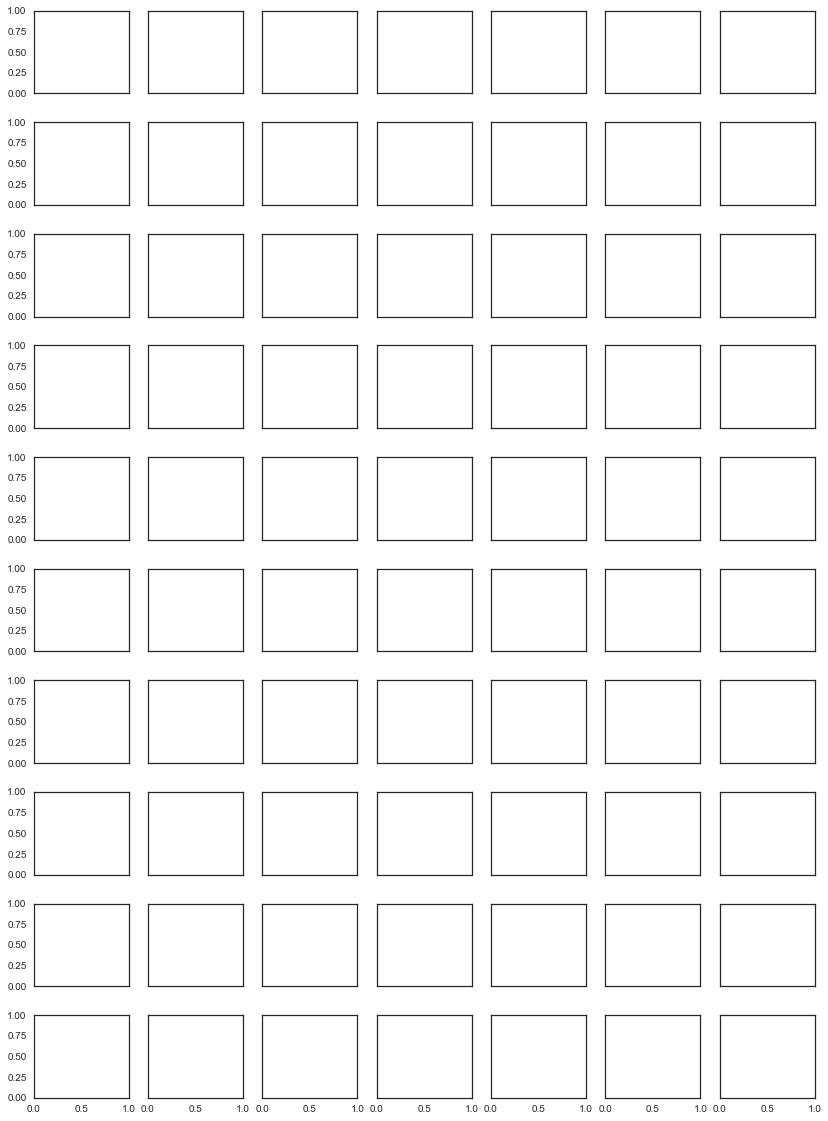

In [61]:
def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)
        
        librosa.display.specshow(clip.logamplitude, sr=Clip.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)

categories = 10
clips_shown = 7
f, axes = plt.subplots(categories, clips_shown, figsize=(clips_shown * 2, categories * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c in range(0, categories):
    for i in range(0, clips_shown):
        plot_clip_overview(clips_10[c][i], axes[c, i])

The *ESC-10* dataset is quite consistent in intra-class characteristics. Separability between classes is also quite good with this smaller dataset. We have some general groups of sounds:
- transient/percussive sounds (*sneezing*), some of them with meaningful temporal structures (*barking dog*, *clock ticking*),
- sound events with a lot of harmonic content (*crying baby*, *crowing rooster*),
- more or less structured noise/soundscapes (*rain*, *sea waves*, *helicopter noise*).

We can hypothesize that the main difficulty in classifying will be to discern inside those groups (e.g. between *clashing waves* and *falling rain*).

The *ESC-50*, owing to a larger number of categories, will be definitely harder in this matter - with some recordings being more ambiguous, especially when background noise comes into play.

In [62]:
clips_50 = load_dataset('ESC-50')

All ESC-50 recordings loaded.


IndexError: list index out of range

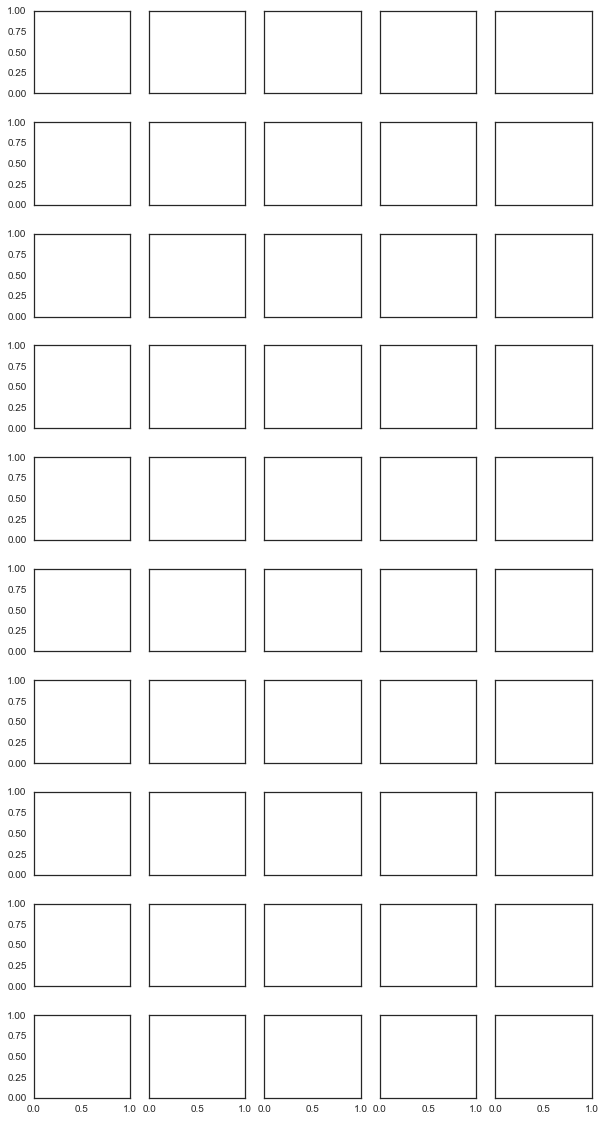

In [63]:


f, axes = plt.subplots(10, 5, figsize=(5 * 2, 10 * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for row in range(0, 10):
    for col in range(0, 5):
        plot_clip_overview(clips_50[col * 10 + row][0], axes[row, col])

There are some very distinct sound sources that can be easily distinguished from other classes by quick visual inspection (e.g. *frog*) and some which are quite similar in their spectral content (*cat*, *crying baby*, *creaking wood*). Part of this comes from their actual perceptual closeness (at times *crying cats* may even do it on purpose [[McComb et al., 2009]](http://dx.doi.org/10.1016/j.cub.2009.05.033)), but most of it is due to sub-optimal representation of the data - human listeners would not judge the task of recognizing between *baby cries* and *creaking door* as challenging, but they normally don't do it by looking at spectrograms.

The main problem is that even such sub-optimal representations are very high-dimensional. Most basic classifiers will need some [dimensionality reduction](http://en.wikipedia.org/wiki/Dimensionality_reduction) applied first.

We will use [Mel-frequency cepstral coefficients](http://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (*MFCC*) and [zero-crossing rate](http://en.wikipedia.org/wiki/Zero-crossing_rate) (*ZCR*) as our baseline features. ZCR is a very simple, yet useful feature, whereas MFCCs are ubiquitous in speech processing and analyzing harmonic content. They may be less suitable for more noise-like environmental sounds, but the goal here is to get a general feel for the characteristics of the dataset, without striving for maximum classification accuracy.

So, first thing worth doing is to look at the distribution of the computed baseline features.

There are multiple ways this can be done, but each visualization perspective will have to, in some manner, reduce the number of dimensions analyzed at the same time (we have multiple categories, clips per category, features per clip).

Let's begin by looking at a **single clip / all features** perspective:

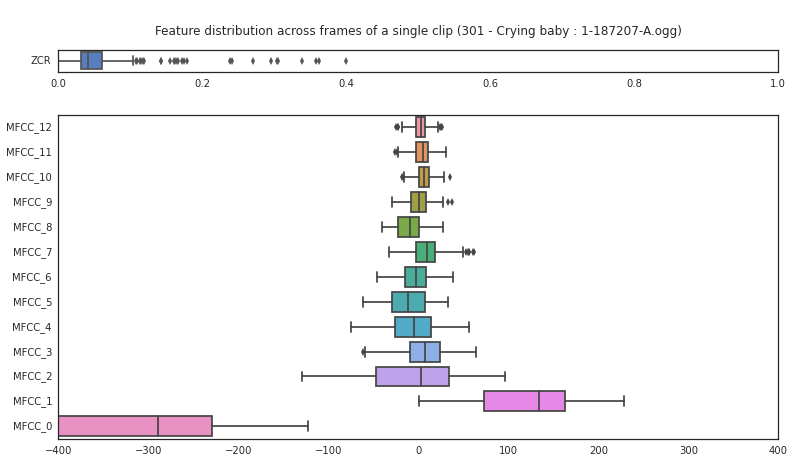

In [14]:
def plot_single_clip(clip):
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clip.mfcc)[1]))
    MFCC = pd.DataFrame(clip.mfcc[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title('Feature distribution across frames of a single clip ({0} : {1})'.format(clip.category, clip.filename), y=1.5)
    sb.boxplot(MFCC, vert=False, order=list(reversed(MFCC.columns)), ax=ax_mfcc)
    sb.boxplot(pd.DataFrame(clip.zcr, columns=['ZCR']), vert=False, ax=ax_zcr)
    
plot_single_clip(clips_50[20][0])

We will not be paying too much attention to the 0th MFCC, as it's not very interesting (derived from the whole log-spectrum).

Looking at the plot, we can see that even with a single clip, the dispersion of initial coefficients ($MFCC_1, MFCC_2$) is quite high. This is to be expected, as most information should have become compressed in first [DCT](http://en.wikipedia.org/wiki/Discrete_cosine_transform) coefficients (an underlying transform used to compute final MFCC values).

This way we can now concentrate our exploration on $MFCC_1$ with an **all clips / single feature** analysis, and see if there's something interesting about it. We will add zero-crossing rate to the pack here, as it's quite distinctive from MFCCs.

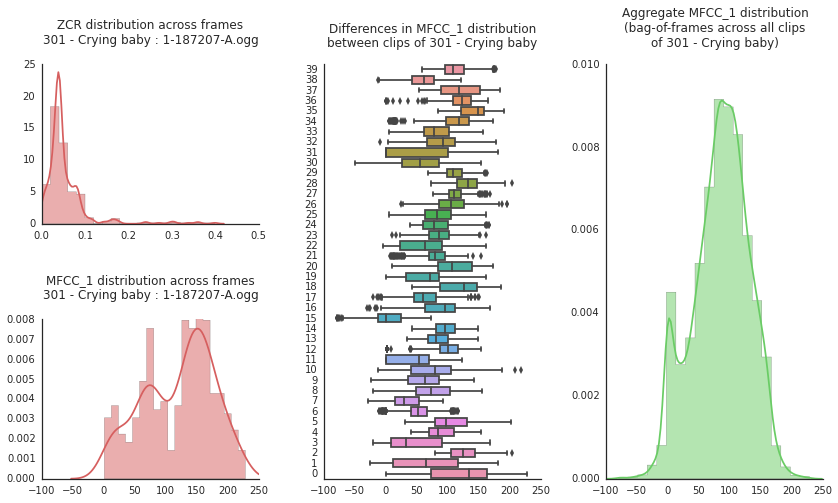

In [15]:
def plot_single_feature_one_clip(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.10)
    sb.distplot(feature, bins=20, hist=True, rug=False,
                hist_kws={"histtype": "stepfilled", "alpha": 0.5},
                kde_kws={"shade": False},
                color=sb.color_palette("muted", 4)[2], ax=ax)

def plot_single_feature_all_clips(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.03)
    sb.boxplot(feature, vert=False, order=list(reversed(feature.columns)), ax=ax)

def plot_single_feature_aggregate(feature, title, ax):    
    sb.despine()
    ax.set_title(title, y=1.03)
    sb.distplot(feature, bins=20, hist=True, rug=False,
                hist_kws={"histtype": "stepfilled", "alpha": 0.5},
                kde_kws={"shade": False},
                color=sb.color_palette("muted", 4)[1], ax=ax)

def generate_feature_summary(category, clip, coefficient):
    title = "{0} : {1}".format(clips_50[category][clip].category, clips_50[category][clip].filename)
    MFCC = pd.DataFrame()
    aggregate = []
    for i in range(0, len(clips_50[category])):
        MFCC[i] = clips_50[category][i].mfcc[:, coefficient]
        aggregate = np.concatenate([aggregate, clips_50[category][i].mfcc[:, coefficient]])    

    f = plt.figure(figsize=(14, 12))
    f.subplots_adjust(hspace=0.6, wspace=0.3)

    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=2)
    ax4 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)

    ax1.set_xlim(0.0, 0.5)
    ax2.set_xlim(-100, 250)
    ax4.set_xlim(-100, 250)
    
    plot_single_feature_one_clip(clips_50[category][clip].zcr, 'ZCR distribution across frames\n{0}'.format(title), ax1)
    plot_single_feature_one_clip(clips_50[category][clip].mfcc[:, coefficient], 'MFCC_{0} distribution across frames\n{1}'.format(coefficient, title), ax2)

    plot_single_feature_all_clips(MFCC, 'Differences in MFCC_{0} distribution\nbetween clips of {1}'.format(coefficient, clips_50[category][clip].category), ax3)

    plot_single_feature_aggregate(aggregate, 'Aggregate MFCC_{0} distribution\n(bag-of-frames across all clips\nof {1})'.format(coefficient, clips_50[category][clip].category), ax4)
    
generate_feature_summary(20, 0, 1)    

What do we get from these plots? One thing is that $MFCC_1$ does indeed vary a lot. Both across frames of a single clip and between particular recordings. Nevertheless, if we look at the aggregated distribution (analyzing all frames of all clips with crying babies), although not perfectly, we could try describing the distribution with some summarizing statistics, e.g. by its mean, standard deviation, kurtosis etc.

To have a better look at this, let's compare the situation with some soundscape recordings of falling rain:

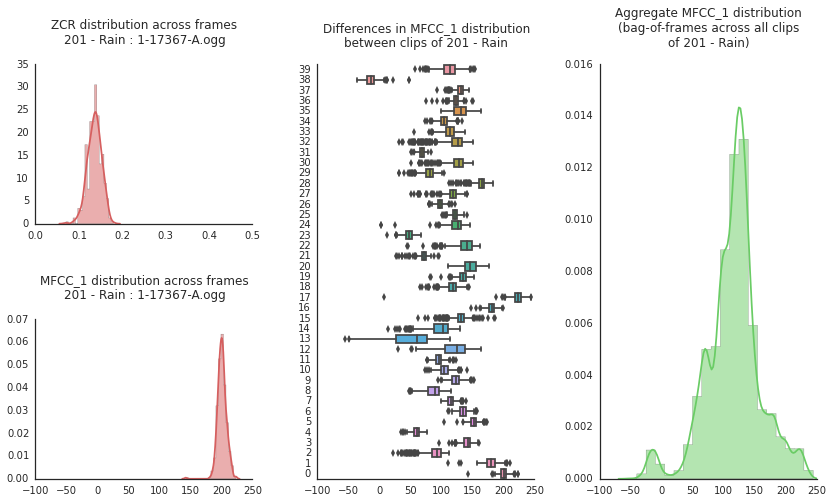

In [16]:
generate_feature_summary(10, 0, 1)

As we can clearly see in this case, the distribution is quite concentrated for individual clips, but we have a lot of variability between different recordings. This makes sense, as most clips will be just some monotonous recordings that are very repetitive on a frame-by-frame basis. One disconcerting fact that we should note is the comparison of the aggregate distribution (right plot) with our previous category (*crying babies*). The differences are rather unremarkable. However, when we compare the distribution among clips (plots in the middle), the repetitive nature of a rainy soundscape can be seen in those shorter bars (less dispersion around the mean value). This would indicate that a sensible feature engineering approach for our learning algorithms would be to summarize the distributions at the clip level instead of category.

Remembering that, we can still have a look at the situation from a perspective of **all clips / all features**:

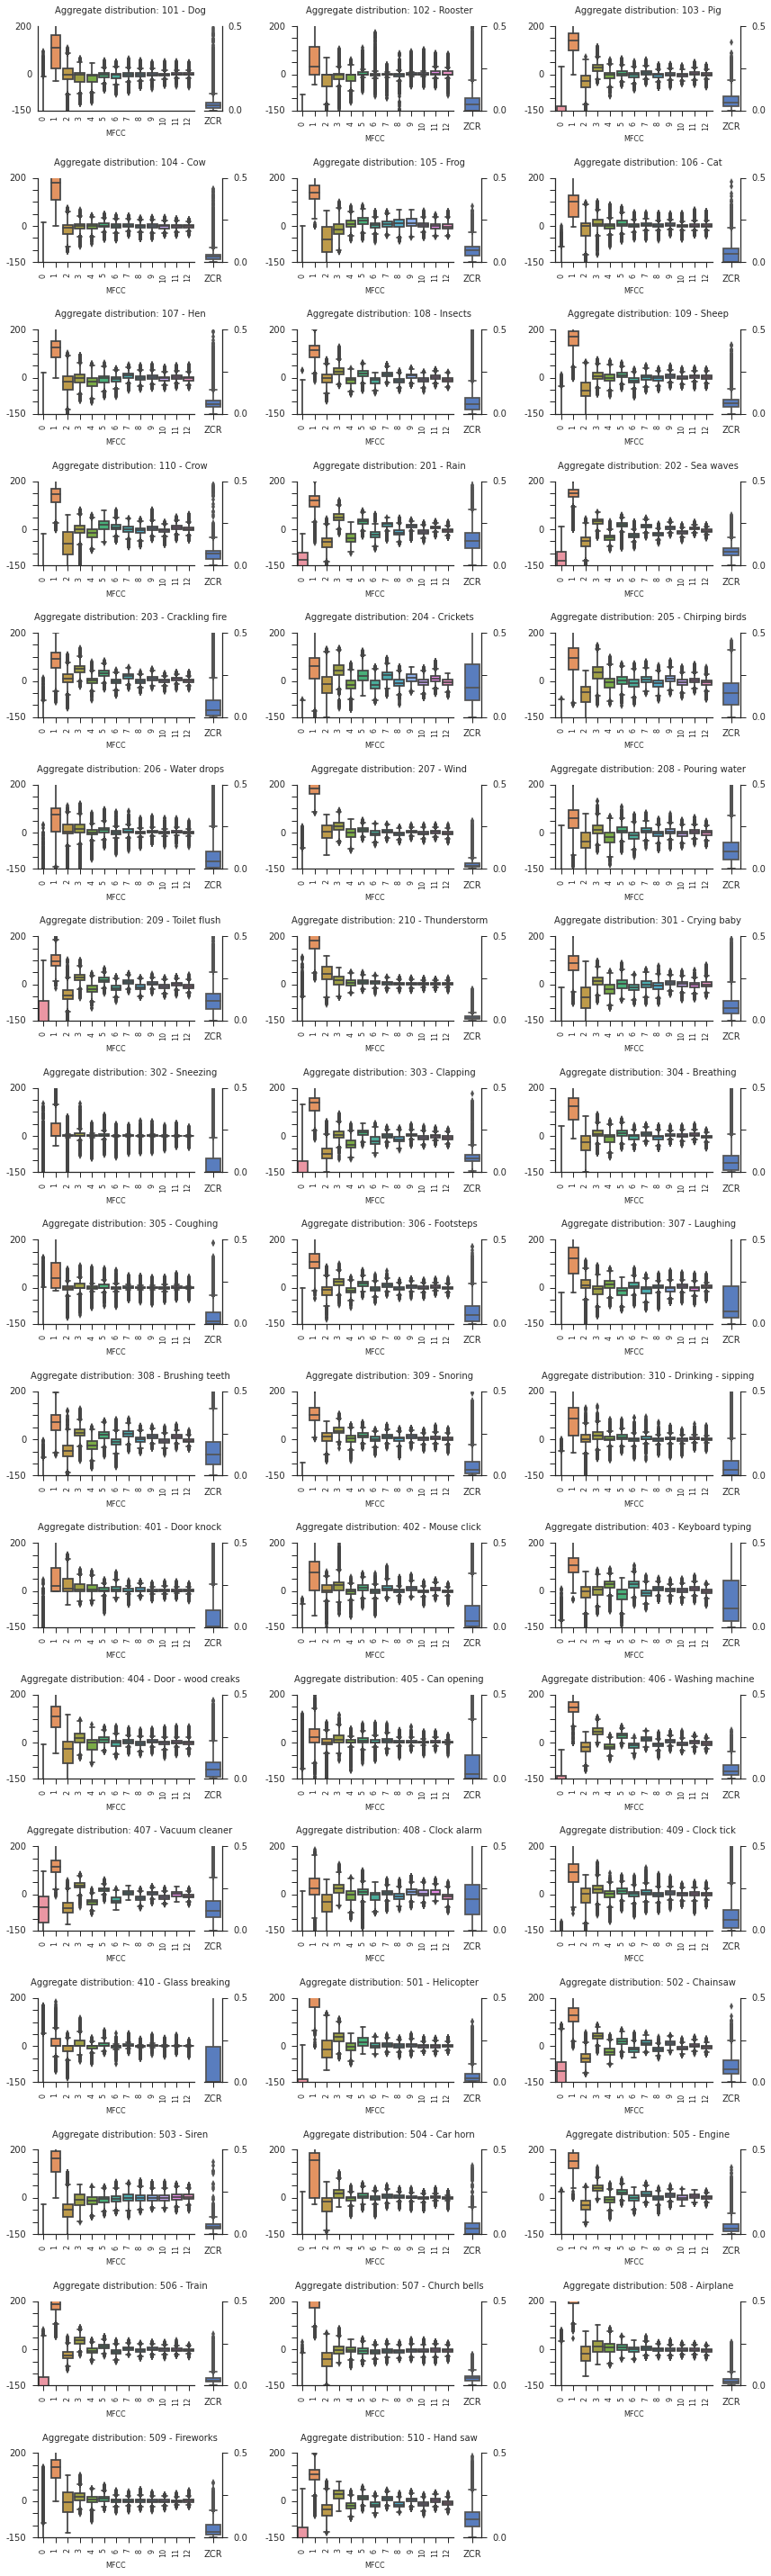

In [17]:
def plot_all_features_aggregate(clips, ax):
    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 0.85, 1.0])
    ax_zcr = add_subplot_axes(ax, [0.9, 0.0, 0.1, 1.0])
    
    sb.set_style('ticks')
    
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clips[0].mfcc)[1]))
    aggregated_mfcc = pd.DataFrame(clips[0].mfcc[:, :], columns=col_names)

    for i in range(1, len(clips)):
        aggregated_mfcc = aggregated_mfcc.append(pd.DataFrame(clips[i].mfcc[:, :], columns=col_names))
        
    aggregated_zcr = pd.DataFrame(clips[0].zcr, columns=['ZCR']) 
    for i in range(1, len(clips)):
        aggregated_zcr = aggregated_zcr.append(pd.DataFrame(clips[i].zcr, columns=['ZCR']))
    
    sb.despine(ax=ax_mfcc)
    ax.set_title('Aggregate distribution: {0}'.format(clips[0].category), y=1.10, fontsize=10)
    sb.boxplot(aggregated_mfcc, vert=True, order=aggregated_mfcc.columns, ax=ax_mfcc)
    ax_mfcc.set_xticklabels(range(0, 13), rotation=90, fontsize=8)
    ax_mfcc.set_xlabel('MFCC', fontsize=8)
    ax_mfcc.set_ylim(-150, 200)
    ax_mfcc.set_yticks((-150, -100, -50, 0, 50, 100, 150, 200))
    ax_mfcc.set_yticklabels(('-150', '', '', '0', '', '', '', '200'))
    
    sb.despine(ax=ax_zcr, right=False, left=True)
    sb.boxplot(aggregated_zcr, vert=True, order=aggregated_zcr.columns, ax=ax_zcr)
    ax_zcr.set_ylim(0.0, 0.5)
    ax_zcr.set_yticks((0.0, 0.25, 0.5))
    ax_zcr.set_yticklabels(('0.0', '', '0.5'))

categories = 50
    
f, axes = plt.subplots(int(np.ceil(categories / 3.0)), 3, figsize=(14, categories * 1))
f.subplots_adjust(hspace=0.8, wspace=0.4)

map(lambda ax: ax.get_xaxis().set_visible(False), axes.flat)
map(lambda ax: ax.get_yaxis().set_visible(False), axes.flat)
map(lambda ax: ax.set_frame_on(False), axes.flat)

for c in range(0, categories):
    plot_all_features_aggregate(clips_50[c], axes.flat[c])

Although we've seen that summarizing the category as a whole will lose a lot of the underlying information, we can still see some regularities here. For instance, lots of soundscape sounds have an interchangeable pattern (bigger/smaller values for odd/even MFCCs). Some mechanical noises exhibit quite concentrated ZCR distributions, presumably due to some strong clean fundamental frequencies appearing in the recordings. In general, we also see a lot of variety, especially in the initial coefficients ($MFCC_1$ and $MFCC_2$).

The last thing we could do right now is to look at class separability when taking solely $MFCC_1$ and $MFCC_2$ into consideration. This way it will be easy to represent this as a 2D scatter plot:

In [18]:
def plot_features_scatter(feature1, feature2, category, category_name, ax, legend='small',
                          pretty_labels=None, font=None, crop_right=None):
    if font is None:
        font = matplotlib.font_manager.FontProperties()
   
    sb.despine()
    category_count = len(clip_features['category'].unique())
    colors = sb.color_palette("Set3", 10)
    plots = []
    labels = []
    markers = [
        (3, 0, 0),     # Triangle up
        (4, 0, 0),     # Rotated square
        (3, 0, 180),   # Triangle down
        (3, 0, 270),   # Triangle right
        (6, 1, 0),     # Star (6)
        (3, 0, 90),    # Triangle left
        (5, 1, 0),     # Star (5)
        (4, 0, 45),    # Square
        (8, 1, 0),     # Star (8)
        (0, 3, 0)      # Circle
    ]
    
    for c in range(0, category_count):
        f1 = feature1[category == c]
        f2 = feature2[category == c]
        size = 50 if c != 9 else 35
        plots.append(ax.scatter(f1, f2, c=colors[c], s=size, marker=markers[c]))
        labels.append(category_name[category == c][0:1][0][6:])

    font.set_size(11)
    ax.set_xlabel(feature1.name, fontproperties=font)
    ax.set_ylabel(feature2.name, fontproperties=font)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.3)
    ax.set_xticklabels(ax.get_xticks(), fontproperties=font)
    ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
    
    if crop_right is not None:
        ax.set_xlim(ax.get_xlim()[0], crop_right)
    
    if pretty_labels is not None:
        labels = pretty_labels
    
    if legend == 'small':
        ax.legend(plots, labels, ncol=2, loc='upper center', frameon=False, fancybox=False, borderpad=1.0, prop=font)
    elif legend == 'big':
        font.set_size(11)
        ax.legend(plots, labels, ncol=5, columnspacing=2, markerscale=1.5, loc='upper center', frameon=False, fancybox=False, borderpad=1.0, prop=font)

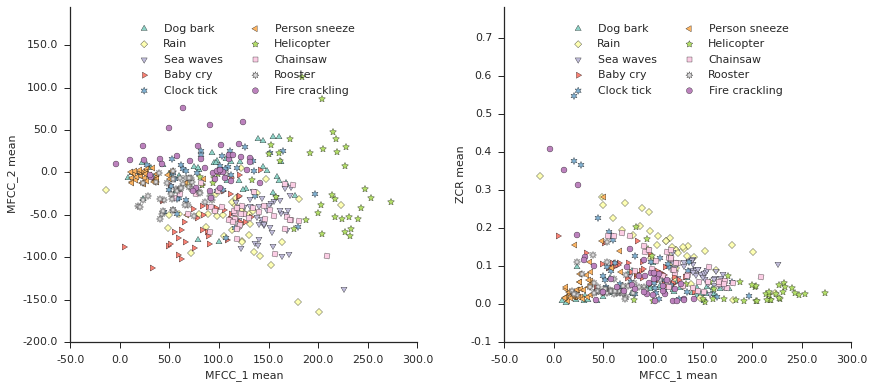

In [19]:
clip_features = pd.DataFrame()

for c in range(0, len(clips_10)):
    for i in range(0, len(clips_10[c])):
        col_names_mean = list('MFCC_{} mean'.format(i) for i in range(np.shape(clips_10[c][i].mfcc)[1]))
        col_names_std = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clips_10[c][i].mfcc)[1]))
        current = pd.DataFrame(np.mean(pd.DataFrame(clips_10[c][i].mfcc[:, :]))[:,np.newaxis].transpose(), columns=col_names_mean)
        current = current.join(pd.DataFrame(np.std(pd.DataFrame(clips_10[c][i].mfcc[:, :]))[:,np.newaxis].transpose(), columns=col_names_std))
        current['ZCR mean'] = np.mean(clips_10[c][i].zcr)
        current['ZCR std dev'] = np.std(clips_10[c][i].zcr)
        current['category'] = c
        current['category_name'] = clips_10[c][i].category
        current['clip'] = i
        clip_features = clip_features.append(current)

f, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_features_scatter(clip_features['MFCC_1 mean'], clip_features['MFCC_2 mean'], clip_features['category'], clip_features['category_name'], axes[0])
plot_features_scatter(clip_features['MFCC_1 mean'], clip_features['ZCR mean'], clip_features['category'], clip_features['category_name'], axes[1])
plt.subplots_adjust(wspace=0.25)

Although we're looking at only two variables at a time (mean values of $MFCC_1$ with either $MFCC_2$ or $ZCR$), some patterns emerge. Solely with this information we could certainly catch most *helicopter* sounds (based on high $MFCC_1$ cutoff), and maybe make some educated guesses about *crying babies* (mostly third quadrant of the $MFCC_1$/$MFCC_2$ plot). Most *rainy soundscapes* also have a clearly defined cutoff when looking at the right plot.

<a id="plot_PCA"></a>

Still, this is based on only three variables in total. For sure, looking at our feature set, they are the most informative ones we have at this moment, but let's try to capture some lost information with another approach to dimensionality reduction. We will use [principal component analysis (PCA)](http://en.wikipedia.org/wiki/Principal_component_analysis) for this:

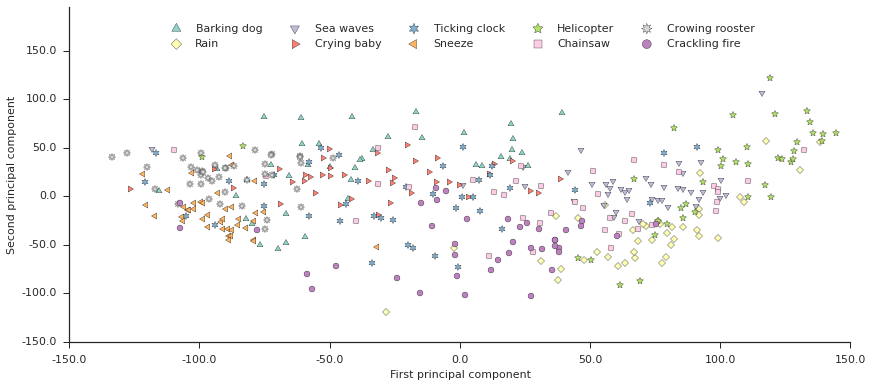

In [20]:
import sklearn as sk

pca = sk.decomposition.PCA(n_components=2)
pca.fit(clip_features.loc[:, 'MFCC_1 mean':'ZCR std dev'])
X = pca.transform(clip_features.loc[:, 'MFCC_1 mean':'ZCR std dev'])
clip_features['First principal component'] = X[:, 0]
clip_features['Second principal component'] = X[:, 1]

f, axes = plt.subplots(1, 1, figsize=(14, 6))
pretty_labels = ['Barking dog', 'Rain', 'Sea waves', 'Crying baby', 'Ticking clock', 'Sneeze', 'Helicopter', 'Chainsaw', 'Crowing rooster', 'Crackling fire']

plot_features_scatter(clip_features['First principal component'], clip_features['Second principal component'],
                      clip_features['category'], clip_features['category_name'],
                      axes, 'big', pretty_labels, crop_right=150)

plt.savefig("figure_pca.pdf")

In comparison to the previous plot ($MFCC_1$ / $MFCC_2$) the first two principal components computed on all our features capture more of the inherent variability in the *ESC-10* dataset. Although far from perfect, the separation between classes is better visible in this way, with some categories (*person sneeze*, *rain*, *sea waves*) forming tight clusters. We still have a lot of overlap - especially with *chainsaw* sounds close to *sea waves*, *rooster crowing* near other short (*sneezing*, *dog barking*) or strongly harmonic (*crying baby*) sounds, and *fire crackling* noises dispersed all over the place. The latter category is actually the one which was the most difficult for human listeners to recognize correctly. This may indicate that this class of recordings is the most nonhomogeneous in the whole dataset.

Concluding our analysis in this section, we should remark that the baseline feature set is indeed rudimentary and should be treated as such. Looking at PCA results one can expect that its discriminatory strength may be insufficient for robust classification, especially with increasing number of categories. Such tasks will certainly require more sophisticated approaches, exploration of which is, however, outside the scope of this work (for a more robust approach, see the more recent paper: *[Environmental Sound Classification with Convolutional Neural Networks](https://github.com/karoldvl/paper-2015-esc-convnet)*).

# Sound classification

## Human accuracy

Before we begin with some baseline approaches to machine classification, let's have a look at how humans can cope with this problem.

As part of this project, a number of participants (the [CrowdFlower platform](http://www.crowdflower.com) was used for this task) tried their best at classifying sounds from both datasets (*ESC-10* and *ESC-50*). Around 4 000 judgments (after quality control cleaning) were provided for each dataset (roughly a dozen per each clip for *ESC-10* and two per clip for *ESC-50*). One can expect that recognizing everyday sounds is a task humans have a lot of experience with. It was clear that, especially with the smaller subset, it shouldn't be difficult. The question was: how easy is it?

Let's commence by analyzing the *ESC-10* results. We can use some Python/Excel magic via the *openpyxl* package to get it straight from the source files.

In [21]:
%%capture

import openpyxl
import itertools

if not os.path.exists('ESC-10/Human.xlsx'):
    urllib.urlretrieve('https://github.com/karoldvl/ESC-10/raw/master/ESC-10-HumanClassification.xlsx', 'ESC-10/Human.xlsx')

def pretty_percentage(value):
    return str(int(np.round(value * 1000)) / 10.0) + '%' if (type(value) is float or type(value) is int) else value
    
def convert_to_df(workbook, cell_range, css_classes=['excel'], raw=False):
    shape = np.shape(tuple(workbook.active[cell_range]))   
    cells = list(itertools.chain(*tuple(workbook.active[cell_range])))
    values = map(lambda c: c.value if '%' not in c.number_format else pretty_percentage(c.value), cells)
    values = map(lambda v: v if v is not None else '', values)
    df = pd.DataFrame(np.reshape(values, shape))
    if raw:
        return df
    return df.to_html(classes=css_classes, index=False, header=False)
    
workbook_esc10 = openpyxl.load_workbook(filename='ESC-10/Human.xlsx')

Confusion matrix with individual counts for *ESC-10*:  
***left*** - *actual (ground truth)*, ***top*** - *prediction (classification by participant)*

In [22]:
IPython.display.HTML(convert_to_df(workbook_esc10, 'B12:M23', ['excel', 'bottom', 'right', 'diagonal']))

,Baby cry,Chainsaw,Clock tick,Dog bark,Fire crackling,Helicopter,Person sneeze,Rain,Rooster,Sea waves,Grand Total
Baby cry,508,,,,,,,,,,508
Chainsaw,,459,,,,7,,,1,,467
Clock tick,,,372,,,,,1,,,373
Dog bark,,,,474,,,1,,,,475
Fire crackling,,1,3,1,395,1,,50,,1,452
Helicopter,,23,,1,2,445,,4,,9,484
Person sneeze,2,,,,,,527,,,,529
Rain,,3,,,33,3,,442,,12,493
Rooster,,,,1,,,,,457,,458
Sea waves,,8,,2,,2,,28,,408,448


Converted to recall for each category (diagonal values):

In [23]:
IPython.display.HTML(convert_to_df(workbook_esc10, 'B46:M56', ['excel', 'right', 'diagonal']))

,Baby cry,Chainsaw,Clock tick,Dog bark,Fire crackling,Helicopter,Person sneeze,Rain,Rooster,Sea waves,Grand Total
Baby cry,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%
Chainsaw,0.0%,98.3%,0.0%,0.0%,0.0%,1.5%,0.0%,0.0%,0.2%,0.0%,100.0%
Clock tick,0.0%,0.0%,99.7%,0.0%,0.0%,0.0%,0.0%,0.3%,0.0%,0.0%,100.0%
Dog bark,0.0%,0.0%,0.0%,99.8%,0.0%,0.0%,0.2%,0.0%,0.0%,0.0%,100.0%
Fire crackling,0.0%,0.2%,0.7%,0.2%,87.4%,0.2%,0.0%,11.1%,0.0%,0.2%,100.0%
Helicopter,0.0%,4.8%,0.0%,0.2%,0.4%,91.9%,0.0%,0.8%,0.0%,1.9%,100.0%
Person sneeze,0.4%,0.0%,0.0%,0.0%,0.0%,0.0%,99.6%,0.0%,0.0%,0.0%,100.0%
Rain,0.0%,0.6%,0.0%,0.0%,6.7%,0.6%,0.0%,89.7%,0.0%,2.4%,100.0%
Rooster,0.0%,0.0%,0.0%,0.2%,0.0%,0.0%,0.0%,0.0%,99.8%,0.0%,100.0%
Sea waves,0.0%,1.8%,0.0%,0.4%,0.0%,0.4%,0.0%,6.2%,0.0%,91.1%,100.0%


As could be expected - human listeners cope well with such an easy task. Accurate classification rates for the *ESC-10* dataset are quite high. On average we get **95.7% accuracy across all categories**. Recall for specific classes (ratio of correct responses for given category of clips) varies between 87.4% (*crackling fire*) to 100% (*crying baby*). Short, distinct sounds (*baby cry*, *clock tick*, *dog bark*, *sneezing person*, *rooster*) are recognizable at rates close to 100%. Some confusion can be seen between recordings of natural soundscapes (*rain*, *crackling fire*, *sea waves*). The former two are mixed interchangeably, with recall values dropping below 90%. Apart from that, around 5% of helicopter recordings were misclassified as chainsaw sounds.

If we dig deeper into the source spreadsheet and catch a glimpse of the statistics for individual clips, there are a couple of black sheep - outliers with really poor performance:
- 010 - Fire crackling/1-17742-A.ogg $\quad[9 / 15 = 60.0\%]$
- 010 - Fire crackling/5-186924-A.ogg $\quad[10 / 18 = 55.6\%]$
- 010 - Fire crackling/5-213802-A.ogg $\quad[3 / 12 = 25.0\%]$
- 002 - Rain/1-29561-A.ogg $\quad[2 / 4 = 50.0\%]$
- 003 - Sea waves/3-164120-A.ogg $\quad[5 / 14 = 35.7\%]$

To make sure that they are only hard and not impossible to recognize, it's good to recheck those particular recordings:

In [24]:
IPython.display.Audio(filename='ESC-10/010 - Fire crackling/1-17742-A.ogg', rate=Clip.RATE)

In [25]:
IPython.display.Audio(filename='ESC-10/010 - Fire crackling/5-186924-A.ogg', rate=Clip.RATE)

In [26]:
IPython.display.Audio(filename='ESC-10/010 - Fire crackling/5-213802-A.ogg', rate=Clip.RATE)

In [27]:
IPython.display.Audio(filename='ESC-10/002 - Rain/1-29561-A.ogg', rate=Clip.RATE)

In [28]:
IPython.display.Audio(filename='ESC-10/003 - Sea waves/3-164120-A.ogg', rate=Clip.RATE)

The third recording is indeed the hardest, but still somewhat recognizable at close inspection. We can verify it with the original description provided by the uploader:
    
    A close recording of a fireplace, burning wood that releases steam due to the temperature.
    
It is to be expected that with *ESC-50* we will have a lot more of such tough calls.

Nevertheless, classifying the *ESC-10* has to be judged as trivial from a human perspective. Although it's hard to bring hard statistics to the table due to the procedure and sample size used, we can provide a rough estimate as somewhere around **95-100% for attentive listeners** with some place for error in case of soundscapes.
    

Understandably, this should deteriorate a bit with 50 categories more closely related to each other.

In addition, there's another factor which comes into play. An increasing number of categories is harder to grasp for untrained participants. With 50, it was still possible to provide them in one coherent view (divided into 5 major groups) without reaching for complicated nested taxonomies, but it was probably on the verge of what is "testable" in such an experiment setup.

The whole confusion matrix for the *ESC-50* dataset is quite big, therefore we will concentrate on individual recall values.

In [29]:
if not os.path.exists('ESC-50/Human.xlsx'):
    urllib.urlretrieve('https://github.com/karoldvl/ESC-50/raw/master/ESC-50-HumanClassification.xlsx', 'ESC-50/Human.xlsx')
    
workbook_esc50 = openpyxl.load_workbook(filename='ESC-50/Human.xlsx')    
offset = (127, 2)

def results_slice(workbook, first, last):
    results_50 = pd.DataFrame(index=['Recall'])

    for c in range(first, last):
        category_name = workbook.active.cell(row=offset[0] + c, column=offset[1]).value
        recall = pretty_percentage(workbook.active.cell(row=offset[0] + c, column=offset[1] + 1 + c).value)
        results_50 = results_50.join(pd.DataFrame({category_name: recall}, index=['Recall']))
    
    return results_50.to_html(classes='cell_right')

IPython.display.HTML(results_slice(workbook_esc50, 0, 10) + results_slice(workbook_esc50, 10, 20) + results_slice(workbook_esc50, 20, 30)
                     + results_slice(workbook_esc50, 30, 40) + results_slice(workbook_esc50, 40, 50))

,Airplane,Breathing,Brushing teeth,Can opening,Car horn,Cat,Chainsaw,Chirping birds,Church bells,Clapping
Recall,67.9%,89.2%,89.3%,80.5%,89.9%,87.5%,82.7%,84.0%,95.2%,91.9%
,Clock alarm,Clock tick,Coughing,Cow,Crackling fire,Crickets,Crow,Crying baby,Dog,Door - wood creaks
Recall,91.6%,89.5%,93.5%,94.1%,63.4%,51.8%,76.6%,98.7%,100.0%,90.0%
,Door knock,Drinking - sipping,Engine,Fireworks,Footsteps,Frog,Glass breaking,Hand saw,Helicopter,Hen
Recall,89.9%,79.7%,81.7%,68.0%,83.1%,75.3%,98.7%,90.0%,63.9%,76.9%
,Insects (flying),Keyboard typing,Laughing,Mouse click,Pig,Pouring water,Rain,Rooster,Sea waves,Sheep
Recall,98.7%,82.7%,97.3%,65.0%,88.6%,74.7%,77.6%,71.2%,68.0%,94.9%
,Siren,Sneezing,Snoring,Thunderstorm,Toilet flush,Train,Vacuum cleaner,Washing machine,Water drops,Wind
Recall,92.6%,87.5%,84.2%,84.9%,87.7%,66.7%,57.7%,34.2%,92.0%,45.8%


The average **accuracy across all 50 categories** is **81.3%** with per class recall varying from 100% (*barking dog*) to 34.1% for washing machine noises. In the latter case, a lot of clips were misclassified as either *helicopter sounds*, *idling engine* or *a vacuum cleaner*.

Without going too much into details, the general tendency for the *ESC-50* dataset seems to divide the dataset into three difficulty levels:
- easy categories (most human sounds, animals and some very distinct sound sources - like *siren*, *water drops*, *breaking glass*),
- average categories (everything in between those two),
- difficult categories (mostly soundscapes and mechanical noises of long duration).

Trained and attentive listeners could probably still score above 90% on this dataset, but we can expect that getting correct labels even for mere $3/4$ of cases will be hard with automatic methods.

## Classification with machine learning techniques

We will begin by using some standard machine learning classifiers on the *ESC-10* dataset. Features (MFCCs and ZCR) will be summarized for each clip (across frames) with their mean and standard deviation.

In [30]:
def create_set(clips):
    cases = pd.DataFrame()

    for c in range(0, len(clips)):
        for i in range(0, len(clips[c])):
            case = pd.DataFrame([clips[c][i].filename], columns=['filename'])
            case['category'] = c
            case['category_name'] = clips[c][i].category
            case['fold'] = clips[c][i].filename[0]
            
            mfcc_mean = pd.DataFrame(np.mean(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            mfcc_std = pd.DataFrame(np.std(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_std.columns = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            case = case.join(mfcc_mean)
            case = case.join(mfcc_std)
            
            case['ZCR mean'] = np.mean(clips[c][i].zcr)
            case['ZCR std dev'] = np.std(clips[c][i].zcr)

            cases = cases.append(case)
    
    cases[['category', 'fold']] = cases[['category', 'fold']].astype(int)
    return cases

In [31]:
cases_10 = create_set(clips_10)
cases_50 = create_set(clips_50)

In [32]:
import sklearn as sk
import sklearn.ensemble

features_start = 'MFCC_1 mean'
features_end = 'ZCR std dev'

def to_percentage(number):
    return int(number * 1000) / 10.0

def classify(cases, classifier='knn', PCA=False, debug=False):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        classifier_name = ''

        if PCA:
            pca = sk.decomposition.PCA()
            pca.fit(train.loc[:, features_start:features_end])
            train.loc[:, features_start:features_end] = pca.transform(train.loc[:, features_start:features_end])
            test.loc[:, features_start:features_end] = pca.transform(test.loc[:, features_start:features_end])

        if classifier == 'knn':
            classifier_name = 'k-NN'
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=8)
            knn.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = knn.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'rf':
            classifier_name = 'Random Forest'
            rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20150420)
            rf.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = rf.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'svm':
            classifier_name = 'Support Vector Machine (SVM)'
            svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
            svm.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = svm.predict(test.loc[:, features_start:features_end])

        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        results.append(accuracy)
        confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
        confusion = confusion + confusion_current
        
        print 'Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy))
        if debug:
            print 'Confusion matrix:\n', confusion_current, '\n'
        
    print 'Average accuracy: {0}%\n'.format(to_percentage(np.mean(results)))
    return confusion, results

def pretty_confusion(confusion_matrix, cases, mode='recall', css_classes=['diagonal', 'cell_right'], raw=False):
    if mode == 'recall':
        confusion_matrix = confusion_matrix * 1000 / np.sum(confusion_matrix, axis=1) / 10.0
        confusion_matrix = np.vectorize(lambda x: '{0}%'.format(x))(confusion_matrix)

    show_headers = False if 'draggable' in css_classes else True
        
    categories = sorted(cases['category'].unique())
    labels = map(lambda c: cases[cases['category'] == c]['category_name'][0:1][0][6:], categories)
    confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    
    if raw:
        return confusion_matrix    
    else:
        return IPython.display.HTML(confusion_matrix.to_html(classes=css_classes, header=show_headers))

In this example three popular classifiers are used: [k-nearest neighbors](http://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [random forest](http://en.wikipedia.org/wiki/Random_forest) and SVM ([support vector machine](http://en.wikipedia.org/wiki/Support_vector_machine)).

Default *scikit-learn* settings will be modified in the following way:
- k-NN with 8 neighbors ([n_neighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)),
- random forest with 500 trees ([n_estimators](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)),
- SVM with linear [kernel](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) and 0.1 penalty.

In [33]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm')
pretty_confusion(confusion_10_rf, cases_10, 'recall')

Classifying fold 1 with k-NN classifier. Accuracy: 58.7%
Classifying fold 2 with k-NN classifier. Accuracy: 72.5%
Classifying fold 3 with k-NN classifier. Accuracy: 67.5%
Classifying fold 4 with k-NN classifier. Accuracy: 72.5%
Classifying fold 5 with k-NN classifier. Accuracy: 62.5%
Average accuracy: 66.7%

Classifying fold 1 with Random Forest classifier. Accuracy: 57.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 78.7%
Classifying fold 3 with Random Forest classifier. Accuracy: 77.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 76.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 73.7%
Average accuracy: 72.7%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 57.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 65.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 73.7%
Classifying

,Dog bark,Rain,Sea waves,Baby cry,Clock tick,Person sneeze,Helicopter,Chainsaw,Rooster,Fire crackling
Dog bark,77.5%,0.0%,0.0%,7.5%,0.0%,12.5%,0.0%,0.0%,2.5%,0.0%
Rain,0.0%,65.0%,5.0%,0.0%,0.0%,0.0%,20.0%,2.5%,0.0%,7.5%
Sea waves,0.0%,10.0%,77.5%,0.0%,2.5%,0.0%,2.5%,7.5%,0.0%,0.0%
Baby cry,5.0%,0.0%,0.0%,85.0%,7.5%,2.5%,0.0%,0.0%,0.0%,0.0%
Clock tick,0.0%,0.0%,0.0%,15.0%,47.5%,7.5%,5.0%,5.0%,5.0%,15.0%
Person sneeze,5.0%,0.0%,0.0%,5.0%,5.0%,80.0%,0.0%,0.0%,2.5%,2.5%
Helicopter,2.5%,17.5%,0.0%,0.0%,0.0%,2.5%,70.0%,5.0%,0.0%,2.5%
Chainsaw,0.0%,15.0%,15.0%,0.0%,2.5%,0.0%,15.0%,52.5%,0.0%,0.0%
Rooster,10.0%,0.0%,0.0%,0.0%,2.5%,2.5%,0.0%,0.0%,85.0%,0.0%
Fire crackling,0.0%,2.5%,0.0%,2.5%,5.0%,2.5%,0.0%,0.0%,0.0%,87.5%


Learning on the *ESC-10* dataset with a 5-fold cross-validation regime results in average accuracies ranging from **66.7%** for the **k-NN** classifier, through **67.5%** (**SVM**) to **72.7%** with **random forest** ensemble. There is some significant dispersion between folds - with validation on the first fold achieving sub-60% accuracy for all classifiers. 

This is to be expected with such small folds (we have 400 clips, so a 5-fold setup results in a split of 320 clips for training / 80 for validation). One way to tackle this issue could be to increase the validation set for each experiment by merging some folds - this would however reduce the number of training cases, which is also undesirable. In general it's a hard problem for datasets this size.

Looking at the presented confusion matrix for the *random forest* classifier (left - *actual*, top - *predicted*, recall on diagonal) - most classes have a true positive rate near 80%, with *rooster* and *crackling fire* classification achieving 85% and 87.5% respectively. That's actually interesting if we compare those results with human abilities in this task. The latter category (*fire crackling*), which scored highest in a machine learning classifier setup, was actually the hardest for human participants, with both humans and machines achieving similar results in recognizing this type of sound event.  

Our machine classifier of choice performs very poorly in recalling *ticking clocks* (47.5%), task which is straightforward for most people owing to very characteristic regular temporal pattern. This is one of the examples when we lose a lot of information by using simple models and more sophisticated approaches should be used (like sequential/state transition models, computing deltas or other time dependent features etc.).

Chainsaw sounds have also created a lot of problems. This is not unexpected if we recall the [class separation plot](#plot_PCA) based on PCA where chainsaw sounds had a lot of overlap with other classes and were very dispersed all other the space. 

Concluding this analysis, we could say that the general performance is satisfactory, considering that we are using a very rudimentary approach. Probably most glaring deficiency in this case is subpar performance on very characteristic sounds, which are easy for human participants (*barking dog*, *crying baby*). A good sound recognition system (from human perspective) should strive for near complete recall for those kind of sounds as they bring a lot of semantical value (foreground sounds) in contrast to most soundscapes which get naturally filtered out as noise/background (not so important) information.

Another notable thing - as these results show, *ESC-10* does indeed present a simplified problem. With baseline approaches achieving 70% accuracy, we can expect that more refined methods should reach near human (above 90%) performance on this dataset. Still, tackling this kind of easy task may yield some useful insights on the way.

The *ESC-50* should be more challenging in this matter and give more room for improvement, although it is still a far cry from large scale sound retrieval. Let's see how the situation changes when we add 40 additional categories to the dataset:

In [34]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm')
pretty_confusion(confusion_50_rf, cases_50, 'recall', ['diagonal', 'draggable'])

Classifying fold 1 with k-NN classifier. Accuracy: 30.0%
Classifying fold 2 with k-NN classifier. Accuracy: 32.5%
Classifying fold 3 with k-NN classifier. Accuracy: 34.0%
Classifying fold 4 with k-NN classifier. Accuracy: 34.7%
Classifying fold 5 with k-NN classifier. Accuracy: 30.0%
Average accuracy: 32.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 41.2%
Classifying fold 2 with Random Forest classifier. Accuracy: 49.5%
Classifying fold 3 with Random Forest classifier. Accuracy: 43.7%
Classifying fold 4 with Random Forest classifier. Accuracy: 46.0%
Classifying fold 5 with Random Forest classifier. Accuracy: 45.2%
Average accuracy: 45.1%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 38.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 39.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 39.2%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 40.5%
Classifying

Dog,62.5%,2.5%,2.5%,2.5%,2.5%,0.0%,7.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.0%,5.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%
Rooster,2.5%,75.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,7.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Pig,0.0%,0.0%,42.5%,2.5%,0.0%,2.5%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,5.0%,0.0%,5.0%,2.5%,0.0%,0.0%,5.0%,2.5%,0.0%,2.5%,0.0%,5.0%,0.0%,0.0%,0.0%,12.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%
Cow,10.0%,0.0%,10.0%,25.0%,0.0%,2.5%,7.5%,0.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.0%,0.0%,2.5%,0.0%,0.0%,0.0%,2.5%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,2.5%,7.5%,0.0%,0.0%,7.5%,5.0%,0.0%,0.0%
Frog,5.0%,0.0%,2.5%,2.5%,55.0%,0.0%,0.0%,0.0%,5.0%,2.5%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,2.5%,2.5%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.0%,0.0%,0.0%,0.0%
Cat,5.0%,2.5%,0.0%,0.0%,10.0%,22.5%,2.5%,0.0%,5.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,17.5%,0.0%,0.0%,2.5%,5.0%,0.0%,0.0%,5.0%,2.5%,0.0%,0.0%,0.0%,7.5%,0.0%,2.5%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Hen,15.0%,5.0%,0.0%,5.0%,2.5%,0.0%,35.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,7.5%,0.0%,0.0%,0.0%,2.5%,7.5%,2.5%,2.5%,5.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Insects,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,35.0%,0.0%,0.0%,0.0%,5.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,0.0%,2.5%,2.5%,0.0%,0.0%,5.0%,2.5%,0.0%,7.5%,0.0%,0.0%,0.0%,2.5%,7.5%,0.0%,0.0%,5.0%,2.5%,0.0%,0.0%,0.0%,2.5%,2.5%,2.5%,0.0%,0.0%,5.0%
Sheep,0.0%,0.0%,0.0%,5.0%,2.5%,5.0%,5.0%,0.0%,35.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.0%,0.0%,7.5%,0.0%,0.0%,2.5%,2.5%,0.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,2.5%,0.0%,0.0%,15.0%,2.5%,0.0%,2.5%
Crow,2.5%,7.5%,0.0%,0.0%,2.5%,5.0%,2.5%,0.0%,2.5%,42.5%,0.0%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,5.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,7.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,2.5%,2.5%,0.0%,0.0%
Rain,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,42.5%,2.5%,0.0%,5.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,7.5%,15.0%,0.0%,0.0%,0.0%,7.5%,0.0%,0.0%,0.0%,5.0%,7.5%,0.0%,0.0%,0.0%,0.0%


The average accuracy when dealing with 50 classes drops to low 40% with **k-NN** achieving the worst performance (**32.2%**), **SVM** in the middle with **39.5%** quite stable between folds, and **45.1%** for **random forest** ensemble&#42;. Folds bigger in absolute terms result in less variability when validating the models.

&#42;&nbsp;*Original experiments reported in the paper gave slightly different results for SVM (39.6%) and random forest (44.3%), most probably due to some recent package changes. Unfortunately, I was unable to pinpoint the exact issue which could be causing this discrepancy*.

Let's visualize the results across datasets for easier comparison:

In [35]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

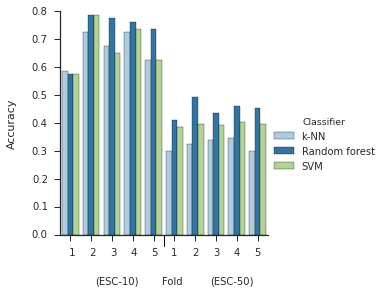

In [36]:
def plot_accuracy_folds(knn_10, rf_10, svm_10, knn_50, rf_50, svm_50):
    def plot_line(start, end):
        line = ax.add_line(matplotlib.lines.Line2D(start, end, color='k', linewidth=1))
        line.set_clip_on(False)
        
    folds_10 = map(lambda i: ' %d' % i, range(1, 6))
    folds_50 = map(lambda i: '%d' % i, range(1, 6))
    accuracy = pd.DataFrame({'Fold': folds_10, 'Accuracy': knn_10, 'Classifier': 'k-NN'})
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_10, 'Accuracy': rf_10, 'Classifier': 'Random forest'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_10, 'Accuracy': svm_10, 'Classifier': 'SVM'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_50, 'Accuracy': knn_50, 'Classifier': 'k-NN'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_50, 'Accuracy': rf_50, 'Classifier': 'Random forest'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_50, 'Accuracy': svm_50, 'Classifier': 'SVM'}))
    
    sb.factorplot('Fold', 'Accuracy', 'Classifier', data=accuracy, kind="bar", hue_order=['k-NN', 'Random forest', 'SVM'],
                          palette=sb.color_palette("Paired", 10))
    
    ax = plt.gca()
    ax.set_xlabel(' ', labelpad=20)
    ax.set_ylabel('Accuracy', labelpad=15)
    ax.annotate('(ESC-10)', xy=(0, 0), xytext=(0.25, 0.015), textcoords='figure fraction')
    ax.annotate('Fold', xy=(0, 0), xytext=(0.425, 0.015), textcoords='figure fraction')
    ax.annotate('(ESC-50)', xy=(0, 0), xytext=(0.55, 0.015), textcoords='figure fraction')
    plot_line((4.5, 4.5), (0.00, -0.04))
    
plot_accuracy_folds(accuracy_10_knn, accuracy_10_rf, accuracy_10_svm, accuracy_50_knn, accuracy_50_rf, accuracy_50_svm)

plt.savefig("figure_accuracy_folds.pdf")

One tendency that stands out when contrasting performance of different classifiers on both datasets is the pronounced drop in accuracy for the simplest (*k-NN*) model. It would indicate that the dependencies between features are more intricate in the bigger dataset, aspect which cannot be reliably captured by models such simple as *k-NN*. In this context ensembling techniques in the form of a *random forest* yield distinctively more favorable results.

The consequences of this are twofold. Firstly, the *ESC-10* dataset is simple enough that classification performance is mostly a direct result of the computed feature set and does not significantly depend on the choice of classifier. For this reason, there is probably not much performance gain possible without devising a more powerful representation of the underlying data. Contrastingly, the *ESC-50* dataset does favor more complex models. This is especially interesting, since most previous research in the domain of environmental sound classification has been concentrating on datasets with quite limited number of categories. The focus was on devising potentially more applicable features and the choice of classifier was regarded most of the time as a secondary if not non-existent problem. Based on this one can make an educated guess that with increasing number of categories (speaking of hundreds to thousands) more robust classifiers will also play a crucial role in the performance of the end system.

To conclude this section, instead of analyzing the confusion matrix (which can be daunting with this size), we will have a look at an overview of **recall values for each class/classifier** combination: 

In [37]:
recalls = pd.DataFrame()

# Collect human recall rates from spreadsheet data
conf_10_human = convert_to_df(workbook_esc10, 'B46:M56', raw=True)
conf_50_human = convert_to_df(workbook_esc50, 'B126:AZ176', raw=True)

# Sanitize labels so we have unified pretty naming for figures
labels_esc10_to_figure = {
    'Baby cry': 'Baby crying',
    'Clock tick': 'Ticking clock',
    'Fire crackling': 'Crackling fire',
    'Person sneeze': 'Sneezing',
    'Dog bark': 'Dog',
    'Brushing teeth': 'Tooth brushing'
}    

labels_esc50_to_figure = {
    'Clock tick': 'Ticking clock',
    'Crying baby': 'Baby crying',
    'Insects (flying)': 'Insects',
    'Door - wood creaks': 'Creaks (door/wood)',
    'Door knock': 'Knocking',
    'Drinking - sipping': 'Drinking / sipping',
    'Brushing teeth' : 'Tooth brushing',
    'Clock alarm': 'Alarm clock'
}

category_order = ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat', 'Hen', 'Insects', 'Sheep', 'Crow',
    'Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops', 'Wind', 'Pouring water', 'Toilet flush', 'Thunderstorm',
    'Baby crying', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps', 'Laughing', 'Tooth brushing', 'Snoring', 'Drinking / sipping',
    'Knocking', 'Mouse click', 'Keyboard typing', 'Creaks (door/wood)', 'Can opening', 'Washing machine', 'Vacuum cleaner', 'Alarm clock', 'Ticking clock', 'Glass breaking',
    'Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train', 'Church bells', 'Airplane', 'Fireworks', 'Hand saw']

def get_recall(conf, index, headers_on=False):
    if headers_on:
        return conf.columns[index], float(conf.iloc[index, index].strip('%')) / 100.0
    else: 
        return conf.loc[index + 1, 0], float(conf.iloc[index + 1, index + 1].strip('%')) / 100.0

def extract_recall_rates(confusion_matrix, category_count, classifier, conversion_dict, category_order):
    df = pd.DataFrame()
    headers_on = '%' in confusion_matrix.iloc[1, 0]   # Check if labels are part of data or headers
    for c in range(0, category_count):
        name, recall = get_recall(confusion_matrix, c, headers_on)
        name = reduce(lambda n, d: n if n != d else conversion_dict[d], conversion_dict, name)    
        df = df.append(pd.DataFrame({'Recall rate': recall, 'Category': name, 'Category ID': category_order.index(name),
                                     'Dataset': 'ESC-{0}'.format(category_count), 'Classifier': classifier}, index=[0]),
                       ignore_index=True)
    return df

recalls = recalls.append(extract_recall_rates(conf_10_human, 10, 'Human', labels_esc10_to_figure, category_order))
recalls = recalls.append(extract_recall_rates(pretty_confusion(confusion_10_knn, cases_10, 'recall', raw=True), 10, 'k-NN', labels_esc10_to_figure, category_order))
recalls = recalls.append(extract_recall_rates(pretty_confusion(confusion_10_rf, cases_10, 'recall', raw=True), 10, 'Random forest', labels_esc10_to_figure, category_order))
recalls = recalls.append(extract_recall_rates(pretty_confusion(confusion_10_svm, cases_10, 'recall', raw=True), 10, 'SVM', labels_esc10_to_figure, category_order))
recalls = recalls.append(extract_recall_rates(conf_50_human, 50, 'Human', labels_esc50_to_figure, category_order))
recalls = recalls.append(extract_recall_rates(pretty_confusion(confusion_50_knn, cases_50, 'recall', raw=True), 50, 'k-NN', labels_esc50_to_figure, category_order))
recalls = recalls.append(extract_recall_rates(pretty_confusion(confusion_50_rf, cases_50, 'recall', raw=True), 50, 'Random forest', labels_esc50_to_figure, category_order))
recalls = recalls.append(extract_recall_rates(pretty_confusion(confusion_50_svm, cases_50, 'recall', raw=True), 50, 'SVM', labels_esc50_to_figure, category_order))

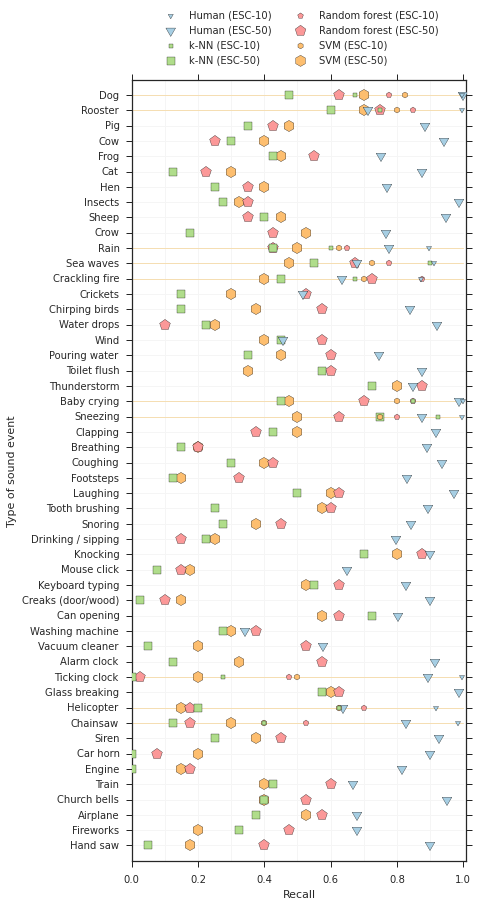

In [38]:
f, ax = plt.subplots(1, 1, figsize=(6, 14))
plots = []

def plot_classifier_recall(classifier, dataset, color_id, dodge=0.0):
    colors = sb.color_palette("Paired", 8)
    markers = [
        (3, 0, 180), (3, 0, 180),
        (4, 0, 45), (4, 0, 45),
        (5, 0, 0), (5, 0, 0),
        (6, 0, 0), (6, 0, 0),
    ]
    size = 125 if color_id % 2 else 35
    #alpha = 0.90 if color_id % 2 else 1.0
    alpha = 1.0
    zorder = 100 - (color_id % 2) * 20 - color_id # ESC-10 on top of ESC-50, smaller markers on top of bigger
    y = 49 - recalls[(recalls['Classifier'] == classifier) & (recalls['Dataset'] == dataset)]['Category ID'].as_matrix() + dodge
    x = recalls[(recalls['Classifier'] == classifier) & (recalls['Dataset'] == dataset)]['Recall rate'].as_matrix()
    plots.append(ax.scatter(x, y, c=colors[int(np.ceil(color_id / 2)) * 2], s=size, marker=markers[color_id],
                            alpha=alpha, zorder=zorder))

plot_classifier_recall('Human', 'ESC-10', 0, 0)
plot_classifier_recall('Human', 'ESC-50', 1, 0)
plot_classifier_recall('k-NN', 'ESC-10', 2, 0)
plot_classifier_recall('k-NN', 'ESC-50', 3, 0)
plot_classifier_recall('Random forest', 'ESC-10', 4, 0)
plot_classifier_recall('Random forest', 'ESC-50', 5, 0)
plot_classifier_recall('SVM', 'ESC-10', 6, 0)
plot_classifier_recall('SVM', 'ESC-50', 7, 0.0)

ax.legend(plots, ('Human (ESC-10)', 'Human (ESC-50)', 'k-NN (ESC-10)', 'k-NN (ESC-50)',
                  'Random forest (ESC-10)', 'Random forest (ESC-50)', 
                 'SVM (ESC-10)', 'SVM (ESC-50)'), loc='upper center', ncol=2, markerscale=1,
                  bbox_to_anchor=(0.5, 1.10))

ax.set_ylim((-1, 50))
ax.set_yticks(range(0, 50))
ax.set_yticklabels(category_order[::-1], fontsize=10)
ax.set_xlim((0.0, 1.01))

ax.set_ylabel('Type of sound event')
ax.set_xlabel('Recall')

for c in range(0, 50):
    ax.add_line(matplotlib.lines.Line2D((0, 1), (c, c), linewidth=1, linestyle='solid', alpha=1.0, color='whitesmoke', zorder=0))
for r in (np.arange(0, 10) / 10.0):
    ax.add_line(matplotlib.lines.Line2D((r, r), (-1, 50), linewidth=1, linestyle='solid', alpha=1.0, color='whitesmoke', zorder=0))    
for c in 49 - (recalls[(recalls['Classifier'] == 'Human') & (recalls['Dataset'] == 'ESC-10')]['Category ID'].as_matrix()):
    ax.add_line(matplotlib.lines.Line2D((0, 1), (c, c), linewidth=1, linestyle='solid', alpha=1.0, color='wheat', zorder=0.1))
    
plt.savefig('figure_recall.pdf', bbox_inches='tight')

This plot compares recall values for each type of sound event between different classifiers and human performance. When adequate, performance for a given class in the limited context of the *ESC-10* dataset (1 out of 10 classification) was also provided.

Some most remakrable insights from this data:
- human participants have no problem with classifying very characteristic sounds (*barking dogs*, *crying babies*) with flawless accuracy independent on the number of possible categories,
- machine learning classifiers perform poorly when compared to their human counterparts, yet the difference is more pronounced for some groups of sounds than the others; for instance, lots of recordings in soundscape/background noise categories prove to be quite ambiguous for human listeners, group which coincidentally scores quite high with automated systems,
- presented approaches fail miserably with some sound sources, especially short ones (*car horn*, *ticking clock*, *water drops*), indicating that discarding temporal dependencies between frames may be the culprit in this situation.
- *SVM* model performed better for animal sounds than *random forest* ensemble; this is not interesting in itself, as it may be an artifact of the data, but it can indicate that using more customized (hierarchical) models for specific broader categories of sounds may be a viable option for large-scale classification systems (with multi-stage classification - first between broad sound types and later between more refined categories, e.g. from bird chirping to species recognition).

At the same time, one has to be careful about presenting far reaching conclusions here, particularly when talking about general human abilities. The sample size in this experiment was quite limited (around 80 observations per category for the larger dataset - values for *ESC-10* should be more reliable with 400 human judgments per category), and more thorough examination would be required to confirm some of those tendencies.

# Conclusion

The aim of this notebook was to present a new dataset suitable for research in environmental sound classification that could help foster open and reproducible research in this field.

We've covered a general overview of the dataset and some baseline approaches to sound classification. The recognition accuracy is far from stellar - but it doesn't strive to be. The goal here was to present an "out-of-the-box" approach (what is possible without much tweaking) and contrast that with human performance (what is the possible goal). Especially with the *ESC-50* dataset, there are copious opportunities to improve the models. This way the task should, hopefully, prove challenging enough for at least a while.

#### Future work & goals

There are numerous ways to expand on this topic, some of which are already in the working:
- compile a rich reproducible survey comparing various established and more esoteric techniques applicable to the classification of environmental sounds (sequential models - HMM, dictionary approaches - e.g. matching pursuit with Gabor atoms, spectrogram template matching etc.),
- evaluate deep neural networks and other deep learning (preferably generative) models in this context, e.g. with unsupervised pre-training using the *ESC-US* dataset,
- explore the *ESC-US* dataset and research possibilities it creates (clustering techniques, using available information from the noisy metadata/tags in weakly-supervised settings and/or a hybrid machine-crowd annotation projects, large scale sound classification).

If you're interested in some details about this or other projects, or just want to contact the author for any other reason, you can reach me at: [karol@dvl.pl](mailto:karol@dvl.pl).

#### Related papers

K. J. Piczak. [Environmental Sound Classification with Convolutional Neural Networks](https://github.com/karoldvl/paper-2015-esc-convnet) in *Proceedings of the IEEE International Workshop on Machine Learning for Signal Processing (MLSP)*. IEEE, 2015. *In press*.

# License

All code in this notebook is available under the terms of the MIT license:

Copyright © 2015 Karol Piczak

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

# Housekeeping

Some additional IPython helper cells.

#### Custom CSS/JS for Excel/Dataframe table rendering

In [39]:
%%javascript

/* Dragger snippet: http://stackoverflow.com/q/3864739/308759 */
$.fn.attachDragger = function(){
    var attachment = false, lastPosition, position, difference;
    $( $(this).selector ).on("mousedown mouseup mousemove",function(e){
        if( e.type == "mousedown" ) attachment = true, lastPosition = [e.clientX, e.clientY];
        if( e.type == "mouseup" ) attachment = false;
        if( e.type == "mousemove" && attachment == true ){
            position = [e.clientX, e.clientY];
            difference = [ (position[0]-lastPosition[0]), (position[1]-lastPosition[1]) ];
            $(this).scrollLeft( $(this).scrollLeft() - difference[0] );
            $(this).scrollTop( $(this).scrollTop() - difference[1] );
            lastPosition = [e.clientX, e.clientY];
        }
    });
    $(window).on("mouseup", function(){
        attachment = false;
    });
}
$("table.draggable").attachDragger();

if ( ! $("#dataframe_tooltip").length ) {
    $("table.draggable").before('<div id="dataframe_tooltip"></div>');
}

$('table.draggable td').hover(function() {
    var cell = $(this);
    var col = cell[0].cellIndex;
    var row = $(cell).parent("tr")[0].sectionRowIndex;
    var table = $(cell).parents("table")[0];
    var actual = $(table).find("tr").eq(row).find("th").eq(0).text();
    var predicted = $(table).find("tr").eq(col - 1).find("th").eq(0).text();
    var value = $(table).find("tr").eq(row).find("td").eq(col - 1).text();
    $("#dataframe_tooltip").html('Actual: ' + actual + '<br />Predicted: ' + predicted + '<br />' + value);
    $("#dataframe_tooltip").show();
}, function() {
    $("#dataframe_tooltip").hide();
}).mousemove(function(e) {
    $("#dataframe_tooltip").css({ top: e.clientY + 10, left: e.clientX + 10});
});

<IPython.core.display.Javascript object>

In [40]:
diagonal_style = '\n'.join(map(lambda i: '''table.diagonal tr:nth-of-type({0}) td:nth-of-type({0}) {{
                               background: #F5F5F5;
                               background: -webkit-gradient(linear, left top, left bottom, from(#F7F7F7), to(#F5F5F5));
                               background: -moz-linear-gradient(top,  #F7F7F7,  #F5F5F5);
                               font-weight: bold;
}}'''.format(i), range(1, 51)))

excel_style = '''<style>
    @import url('https://fonts.googleapis.com/css?family=PT+Sans');
    #dataframe_tooltip {
        display:none;
        position:fixed;
        width: 150px;
        padding:10px;
        -moz-box-shadow: 0 1px 2px #d1d1d1;
        -webkit-box-shadow: 0 1px 2px #d1d1d1;
        box-shadow: 0 1px 2px #d1d1d1;
        border: 1px solid #e0e0e0;
        background: #ffffff;
        background: -webkit-gradient(linear, left top, left bottom, from(#ffffff), to(#fbfbfb));
        background: -moz-linear-gradient(top, #ffffff, #fbfbfb);   
        color:#444;
        font: 11px 'PT Sans';
    }
    table.dataframe.draggable {
        display: block;
        max-height: 750px;
        overflow: scroll;
        -webkit-touch-callout: none;
        -webkit-user-select: none;
        -khtml-user-select: none;
        -moz-user-select: none;
        -ms-user-select: none;
        user-select: none;
        font-size: 10px;
        cursor: -webkit-grab;
        cursor:-moz-grab;
    }
    table.dataframe.draggable:active {
        cursor: -webkit-grabbing;
        cursor: -moz-grabbing;
    }
    table.dataframe.draggable thead th {
        font-size: 6px;
    }
    table.dataframe.draggable th:first-child {
        min-width: 100px;
    }
    table.dataframe {
        border:#ccc 1px solid;
        -moz-box-shadow: 0 1px 2px #d1d1d1;
        -webkit-box-shadow: 0 1px 2px #d1d1d1;
        box-shadow: 0 1px 2px #d1d1d1;
        font: 13px 'PT Sans', Arial, sans-serif;
        color:#444;
    }
    table.dataframe td, table.dataframe th {
        border: 1px solid #e0e0e0;
        background: #ffffff;
        background: -webkit-gradient(linear, left top, left bottom, from(#ffffff), to(#fbfbfb));
        background: -moz-linear-gradient(top, #ffffff, #fbfbfb);     
    }
    table.dataframe thead th {
        text-align: center;
    }
    table.dataframe tr:hover td {
        background: #f2f2f2 !important;
        background: -webkit-gradient(linear, left top, left bottom, from(#f2f2f2), to(#f0f0f0)) !important;
        background: -moz-linear-gradient(top,  #f2f2f2,  #f0f0f0) !important;
    }
    table.dataframe td, table.dataframe th {
        width: 85px;
    }
    table.dataframe tr th:first-child {
        width: 100px;
    }
    table.dataframe.cell_right td {
        text-align: right;
        padding-right: 10px;
    }
    table.excel td {
        width: 75px;
        text-align: right;
        padding-right: 10px;
    }
    table.excel td:nth-child(1) {
        width: 100px;
    }
    table.excel tr:first-child td, table.excel td:first-child, table.dataframe th {
        background: #ededed;
        background: -webkit-gradient(linear, left top, left bottom, from(#ededed), to(#ebebeb));
        background: -moz-linear-gradient(top,  #ededed,  #ebebeb);
        font-weight: bold;
    }
    table.excel.bottom tr:last-child td, table.excel.right td:last-child {
        background: #FFFDFA;
        background: -webkit-gradient(linear, left top, left bottom, from(#FFFEFC), to(#FFFDFA));
        background: -moz-linear-gradient(top,  #FFFEFC,  #FFFDFA);
        font-weight: bold;
    }''' + diagonal_style + '''</style>'''

IPython.display.HTML(excel_style)

#### MFCC visualization

Most of the time I forget how the specific Mel-Frequency Cepstral Coefficients relate to the actual spectrum, so here's a quick plot:

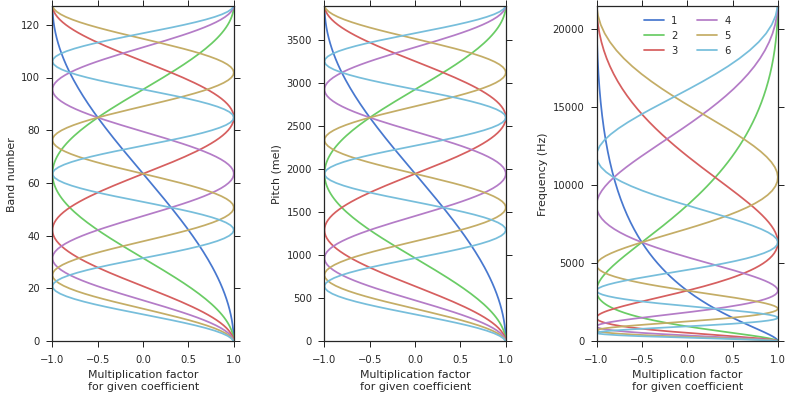

In [41]:
import math

def hertz_to_mel(freq):
    # Using this implementation for reference: http://cran.r-project.org/web/packages/seewave/
    return 1127.01048 * math.log(1 + (freq / 700.0))
    
def mel_to_hertz(pitch):
    return 700.0 * (math.exp(pitch / 1127.01048) - 1)
    
max_freq = 22050
bands = 128

f, axes = plt.subplots(1, 3, figsize=(13, 6))

r = np.arange(0, bands)
r_mel = np.arange(0, bands) / float(bands) * hertz_to_mel(max_freq)
r_hz = map(mel_to_hertz, r_mel)

plt.subplots_adjust(wspace=0.5)

for coeff in range(1, 7):
    axes[0].plot(np.cos(np.pi / bands * (r + 0.5) * coeff), r, marker='', label=coeff)
    axes[1].plot(np.cos(np.pi / bands * (r + 0.5) * coeff), r_mel, marker='', label=coeff)
    axes[2].plot(np.cos(np.pi / bands * (r + 0.5) * coeff), r_hz, marker='', label=coeff)

    axes[0].set_ylabel('Band number')
    axes[0].set_xlabel('Multiplication factor\nfor given coefficient')
    axes[0].set_ylim((r[0], r[-1]))
    axes[1].set_ylabel('Pitch (mel)')
    axes[1].set_xlabel('Multiplication factor\nfor given coefficient')
    axes[1].set_ylim((r_mel[0], r_mel[-1]))
    axes[2].set_ylabel('Frequency (Hz)')
    axes[2].set_ylim((r_hz[0], r_hz[-1]))
    axes[2].set_xlabel('Multiplication factor\nfor given coefficient')
    
    axes[2].legend(loc='upper center', ncol=2)

Even more fancy visualization as time-frequency patches by Ken Schutte & James Glass in [Features and Classifiers for Robust Automatic Speech Recognition [2007]](http://publications.csail.mit.edu/abstracts/abstracts07/kschutte/kschutte.html). Copyright by the original authors, linked here under *fair use* policy:

![MFCC as visual time-frequency patches](http://publications.csail.mit.edu/abstracts/abstracts07/kschutte/mfcc39new.png)

In [42]:
%%javascript

if ( ! $("#footer_navi").length ) {
    $("div.container").last().after('<div id=\"footer_navi\">\
    <a href=\"#ESC:-Dataset-for-Environmental-Sound-Classification\">Introduction</a> | \
    <a href=\"#Setup\">Setup</a> | \
    <a href=\"#Exploratory-analysis\">Exploratory analysis</a> | \
    <a href=\"#Human-accuracy\">Human accuracy</a> | \
    <a href=\"#Classification-with-machine-learning-techniques\">Classification with machine learning techniques</a> | \
    <a href=\"#Conclusion\">Conclusion</a>\
    </div>');
}

<IPython.core.display.Javascript object>

---

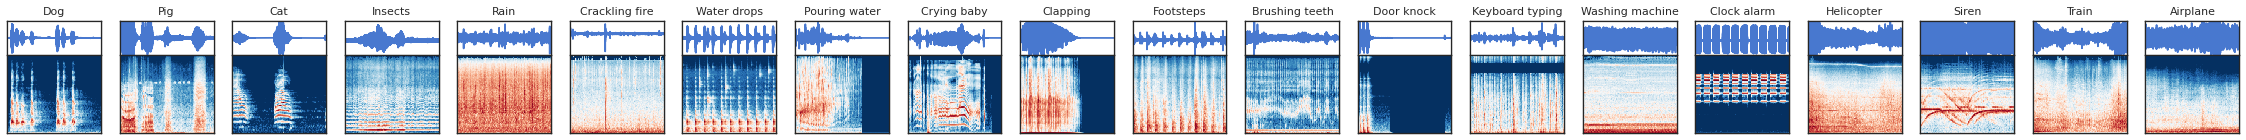

In [73]:
def plot_clip_short(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0}'.format(clip.category[6:]), {'fontsize': 11}, y=1.03)
        
        librosa.display.specshow(clip.logamplitude, sr=Clip.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)
        
categories = 20
clips_shown = 1
f, axes = plt.subplots(clips_shown, categories, figsize=(categories * 2, clips_shown * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c in range(0, 20):
    for i in range(0, clips_shown):
        plot_clip_short(clips_50[int(c * 2.5)][i+10], axes[c])
        
plt.savefig('Figures/poster-samples-long.pdf', bbox_inches='tight')        

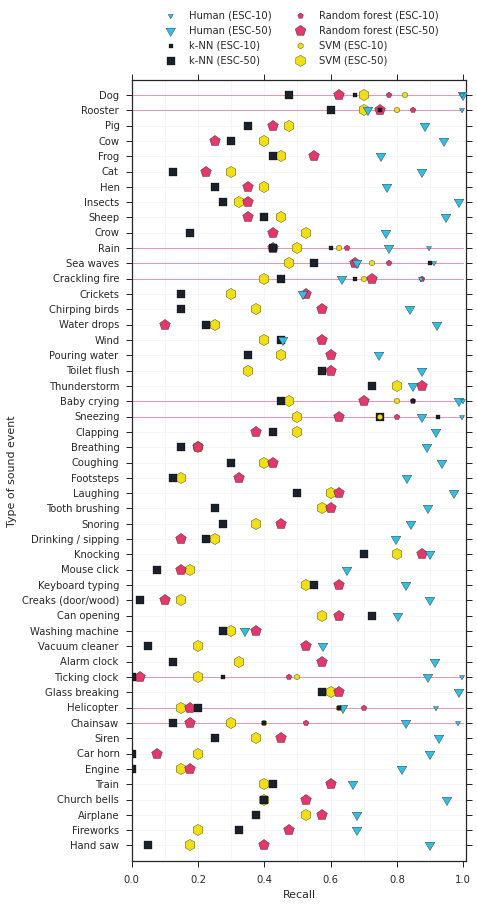

In [86]:
f, ax = plt.subplots(1, 1, figsize=(6, 14))
plots = []

def plot_classifier_recall(classifier, dataset, color_id, dodge=0.0):
    #colors = sb.color_palette("Paired", 8)
    colors = sb.color_palette(('#35bde4', '#35bde4', '#1b212a', '#1b212a', '#e2386c', '#e2386c', '#efdf14', '#efdf14'))
    markers = [
        (3, 0, 180), (3, 0, 180),
        (4, 0, 45), (4, 0, 45),
        (5, 0, 0), (5, 0, 0),
        (6, 0, 0), (6, 0, 0),
    ]
    size = 125 if color_id % 2 else 35
    #alpha = 0.90 if color_id % 2 else 1.0
    alpha = 1.0
    zorder = 100 - (color_id % 2) * 20 - color_id # ESC-10 on top of ESC-50, smaller markers on top of bigger
    y = 49 - recalls[(recalls['Classifier'] == classifier) & (recalls['Dataset'] == dataset)]['Category ID'].as_matrix() + dodge
    x = recalls[(recalls['Classifier'] == classifier) & (recalls['Dataset'] == dataset)]['Recall rate'].as_matrix()
    plots.append(ax.scatter(x, y, c=colors[int(np.ceil(color_id / 2)) * 2], s=size, marker=markers[color_id],
                            alpha=alpha, zorder=zorder))

plot_classifier_recall('Human', 'ESC-10', 0, 0)
plot_classifier_recall('Human', 'ESC-50', 1, 0)
plot_classifier_recall('k-NN', 'ESC-10', 2, 0)
plot_classifier_recall('k-NN', 'ESC-50', 3, 0)
plot_classifier_recall('Random forest', 'ESC-10', 4, 0)
plot_classifier_recall('Random forest', 'ESC-50', 5, 0)
plot_classifier_recall('SVM', 'ESC-10', 6, 0)
plot_classifier_recall('SVM', 'ESC-50', 7, 0.0)

ax.legend(plots, ('Human (ESC-10)', 'Human (ESC-50)', 'k-NN (ESC-10)', 'k-NN (ESC-50)',
                  'Random forest (ESC-10)', 'Random forest (ESC-50)', 
                 'SVM (ESC-10)', 'SVM (ESC-50)'), loc='upper center', ncol=2, markerscale=1,
                  bbox_to_anchor=(0.5, 1.10))

ax.set_ylim((-1, 50))
ax.set_yticks(range(0, 50))
ax.set_yticklabels(category_order[::-1], fontsize=10)
ax.set_xlim((0.0, 1.01))

ax.set_ylabel('Type of sound event')
ax.set_xlabel('Recall')

for c in range(0, 50):
    ax.add_line(matplotlib.lines.Line2D((0, 1), (c, c), linewidth=1, linestyle='solid', alpha=1.0, color='whitesmoke', zorder=0))
for r in (np.arange(0, 10) / 10.0):
    ax.add_line(matplotlib.lines.Line2D((r, r), (-1, 50), linewidth=1, linestyle='solid', alpha=1.0, color='whitesmoke', zorder=0))    
for c in 49 - (recalls[(recalls['Classifier'] == 'Human') & (recalls['Dataset'] == 'ESC-10')]['Category ID'].as_matrix()):
    ax.add_line(matplotlib.lines.Line2D((0, 1), (c, c), linewidth=1, linestyle='solid', alpha=0.5, color='#e2386c', zorder=0.1))
    
plt.savefig('figure_recall_poster.pdf', bbox_inches='tight')

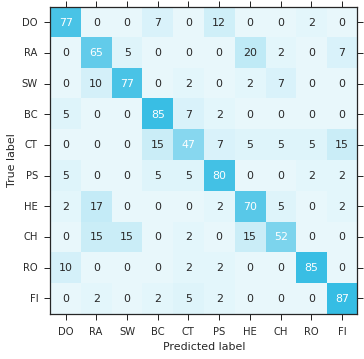

In [194]:
conf = confusion_10_rf * 1000 / 10.0 / confusion_10_rf.sum(axis=1)[:, np.newaxis]
plt.imshow(conf, interpolation='nearest', cmap=sb.light_palette((53./255., 189./255., 228/255.), input="rgb", as_cmap=True))
ticks = ['DO', 'RA', 'SW', 'BC', 'CT', 'PS', 'HE', 'CH', 'RO', 'FI']
plt.xticks(range(0, 10), ticks)
plt.yticks(range(0, 10), ticks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

for x in range(10):
    for y in range(10):
        if x == y:
            plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='white')
        else:
            plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center')
            
plt.savefig('figure_conf_rf_poster.pdf', bbox_inches='tight')            

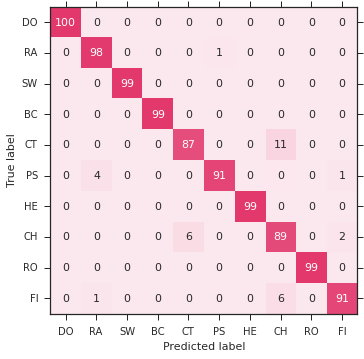

In [195]:
conf = convert_to_df(workbook_esc10, 'C13:L22', raw=True)
conf[conf == ''] = 0
conf = conf.applymap(int)
conf = conf.as_matrix()
conf = conf * 1000 / 10.0 / conf.sum(axis=1)[:, np.newaxis]

plt.imshow(conf, interpolation='nearest', cmap=sb.light_palette((226./255., 56./255., 108/255.), input="rgb", as_cmap=True))
ticks = ['DO', 'RA', 'SW', 'BC', 'CT', 'PS', 'HE', 'CH', 'RO', 'FI']
plt.xticks(range(0, 10), ticks)
plt.yticks(range(0, 10), ticks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

for x in range(10):
    for y in range(10):
        if x == y:
            plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='white')
        else:
            plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center')
            
plt.savefig('figure_conf_human_poster.pdf', bbox_inches='tight')                        

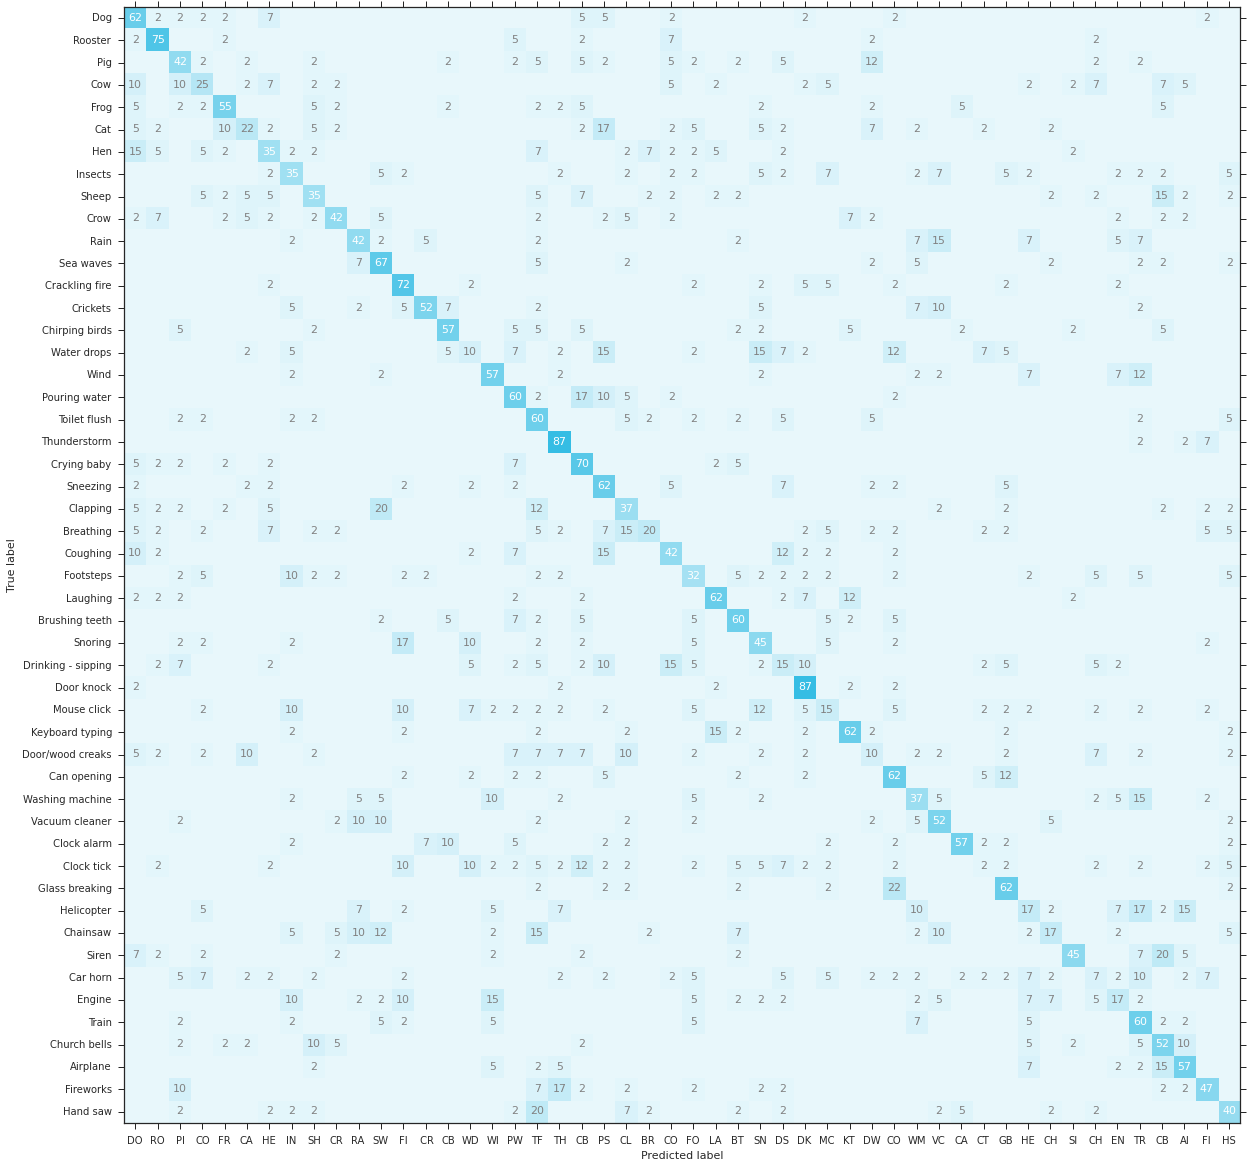

In [196]:
f = plt.figure(figsize=(20, 20))
conf = confusion_50_rf * 1000 / 10.0 / confusion_50_rf.sum(axis=1)[:, np.newaxis]
plt.imshow(conf, interpolation='nearest', cmap=sb.light_palette((53./255., 189./255., 228/255.), input="rgb", as_cmap=True))
#plt.imshow(conf, interpolation='nearest', cmap=sb.light_palette((226./255., 56./255., 108/255.), input="rgb", as_cmap=True))

ticks = ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat', 'Hen', 'Insects', 'Sheep', 'Crow', 'Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops', 'Wind', 'Pouring water', 'Toilet flush', 'Thunderstorm', 'Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps', 'Laughing', 'Brushing teeth', 'Snoring', 'Drinking - sipping', 'Door knock', 'Mouse click', 'Keyboard typing', 'Door/wood creaks', 'Can opening', 'Washing machine', 'Vacuum cleaner', ' Clock alarm', 'Clock tick', 'Glass breaking', 'Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train', 'Church bells', 'Airplane', 'Fireworks', 'Hand saw']
short_ticks = ['DO', 'RO', 'PI', 'CO', 'FR', 'CA', 'HE', 'IN', 'SH', 'CR', 'RA', 'SW', 'FI', ' CR', 'CB', 'WD', 'WI', 'PW', 'TF', 'TH', 'CB', 'PS', 'CL', 'BR', 'CO', 'FO', 'LA', 'BT', 'SN', 'DS', 'DK', 'MC', 'KT', 'DW', 'CO', 'WM', 'VC', 'CA', 'CT', 'GB', 'HE', 'CH', 'SI', 'CH', 'EN', 'TR', 'CB', 'AI', 'FI', 'HS']
plt.xticks(range(0, 50), short_ticks)
plt.yticks(range(0, 50), ticks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

for x in range(50):
    for y in range(50):
        if x == y:
            if int(conf[y, x]) > 25:
                plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='white')
            else:
                plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='gray')
            pass

plt.savefig('figure_conf_50_light_poster.pdf', bbox_inches='tight')                    
        
for x in range(50):
    for y in range(50):
        if x != y:
            if int(conf[y, x]) != 0:
                plt.text(x, y + 0.1, int(conf[y, x]), fontsize=11, ha='center', color='gray')
                
plt.savefig('figure_conf_50_dense_poster.pdf', bbox_inches='tight')                                    

In [ ]:
def plot_accuracy_folds(knn_10, rf_10, svm_10, knn_50, rf_50, svm_50):
    def plot_line(start, end):
        line = ax.add_line(matplotlib.lines.Line2D(start, end, color='k', linewidth=1))
        line.set_clip_on(False)
        
    folds_10 = map(lambda i: ' %d' % i, range(1, 6))
    folds_50 = map(lambda i: '%d' % i, range(1, 6))
    accuracy = pd.DataFrame({'Fold': folds_10, 'Accuracy': knn_10, 'Classifier': 'k-NN'})
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_10, 'Accuracy': rf_10, 'Classifier': 'Random forest'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_10, 'Accuracy': svm_10, 'Classifier': 'SVM'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_50, 'Accuracy': knn_50, 'Classifier': 'k-NN'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_50, 'Accuracy': rf_50, 'Classifier': 'Random forest'}))
    accuracy = accuracy.append(pd.DataFrame({'Fold': folds_50, 'Accuracy': svm_50, 'Classifier': 'SVM'}))
    
    sb.factorplot('Fold', 'Accuracy', 'Classifier', data=accuracy, kind="bar", hue_order=['k-NN', 'Random forest', 'SVM'],
                          palette=sb.color_palette(('#1b212a', '#e2386c', '#efdf14')), aspect=1.5, legend_out=False)
    
    ax = plt.gca()
    ax.set_xlabel(' ', labelpad=20)
    ax.set_ylabel('Accuracy', labelpad=15)
    ax.annotate('(ESC-10)', xy=(0, 0), xytext=(0.3, 0.015), textcoords='figure fraction')
    ax.annotate('Fold', xy=(0, 0), xytext=(0.54, 0.055), textcoords='figure fraction')
    ax.annotate('(ESC-50)', xy=(0, 0), xytext=(0.73, 0.015), textcoords='figure fraction')
    plot_line((4.5, 4.5), (0.00, -0.04))
    
plot_accuracy_folds(accuracy_10_knn, accuracy_10_rf, accuracy_10_svm, accuracy_50_knn, accuracy_50_rf, accuracy_50_svm)

plt.savefig("figure_accuracy_folds_poster.pdf")